# Test Time Adaptation through Evolutionary Optimised Augmentation

 Giacomo Tomezzoli (241091) &  Davide Vandelli (240207)
 <br/>**Contact:** `{giacomo.tomezzoli, davide.vandelli} [at] studenti.unitn.it`
 <br/>**Github:** `https://github.com/gzemo...`

## Abstract

Abstract section

---

## Table of contents:
1. Introduction (here the link to the section)
2. Methods
3. Results
4. Discussion
5. Conclusion
6. References


---

## Introduction
Topic introduction, literature review motivation and novelty.


## Motivation
Ideas that let us formalised a new evolutionary based approach.

---

## Evolutionary guided approach for cropping selection
(describe the search space of each possibile augmentation and state what you would like to test in the present work: optimised cropping procedure)

### Entropy pooling

### Frequency map

### Covariance Matrix Adaptation Evolutionary Strategy (CMA-ES)

### Search space fitness definition

### Addressing for small cropping regions
We should the rationale of using a SR model: I belive we need to state the issue that very small regions may be actually hindering the final prediction if linearly interpolated back to the model input size without having any assumption over the real improvement SR model can have while rescaling images. *Then* on the discussion section we should state that, given no improvement, the hyparams tuning procedure was adressed by excluding that approach.

### Hyperparameter definition

## Augmentation

Auto-augment description (RL process optimizing augmentation function search over ImageNet data

## Learning and Inference procedure

### Search algorithm
(try to follow the scheme of some of previous studies on the topic)




And here we will go in detail about the technical requirements, and afterwards the general experimental methods we are using.

IMPORTANT: this notebook should never be used on jupyter notebook, but only on CoLAB, because some commands for preparation will change.

In [1]:
! pip install timm cmaes tqdm einops kornia supervision -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 52.5 MB/s eta 0:00:00


In [8]:
%matplotlib inline

import os
import csv
import copy
import time

import itertools
import tarfile
import numpy as np
from PIL import Image
from cmaes import CMA
from tqdm import tqdm
from io import BytesIO

import timm
from timm.models import create_model

import torch
import torchvision
import torchvision.models as models

import torchvision.transforms.v2 as v2
from torch.nn.modules.utils import _pair, _quadruple
from torch.distributions import Categorical
import torchvision.transforms.functional as ttf

import matplotlib.pyplot as plt
import matplotlib.patches as patches

#from google.colab import drive
from transformers import ResNetForImageClassification # not used

from scipy.stats import entropy
from matplotlib import pyplot as plt

import boto3 # aws s3
from pathlib import Path
import gdown


# defining amount of Classes
NCLASSES = 1000

# defining DEVICE
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

print(DEVICE)

cuda:0


### General set up
Mapping folder name and class number to Imagenet-1k true labels


In [7]:
LABELS, FOLDERS, COMMON = dict(), dict(), dict()

# preparing Imagenet-A_1k class number to label map
# {nclass : label_origin}
with open("imagenet1k_classes.txt", "r") as f:
    for i, line in enumerate(f.readlines()):
        if i == 0: continue
        items = line.strip().split("|")
        LABELS[int(items[1].strip())] = items[2].strip().lower()

# preparing testfolder class to name
# {foldername : label_folder}
with open("folder2label_correct.txt", "r") as f:
    for line in f.readlines():
        line = line.strip().split(" ")
        foldername,  label = line[0], " ".join(line[2].split("_")).lower()
        FOLDERS[foldername] = label

# preparing folder labels to real Imagenet-A_1k labels map
# {label_origin : label_folder}
for k1 in FOLDERS.keys():
    query = FOLDERS[k1]
    for k2 in LABELS.keys():
        name, name_list = LABELS[k2], LABELS[k2].split(", ")
        for item in name_list:
            if query == item:
                COMMON[name] = query
                break
            break

### Backbone loading

In [5]:
if not os.path.exists("memo"):
    ! git clone https://github.com/zhangmarvin/memo.git memo -q
    ! mv memo/imagenet-exps memo/imagenet_exps

#if not os.path.exists("RVT"):
#    ! git clone https://github.com/vtddggg/Robust-Vision-Transformer.git RVT -q
#from RVT.robust_models import *

In [6]:
# load and explain from where you gathered the models backbone: consider the idea
# to load also RVT* by giving enough explanations about the need to pre-load the model's
# weights through the official repository.

from memo.imagenet_exps.utils.third_party import *

def backbone_loading(modelname):
    """
    Pretrained visual encoder backbone loading with state dictionary.
    Returns:
        model (torch.nn.Module)
        state (torch.nn.Module.state_dict) pretrained weights
    """
    # deprecated: #model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

    # Resnet50 params from torchvision (1k_v1)
    #if modelname == "resnet":
    #    model_params = models.ResNet50_Weights.IMAGENET1K_V1
    #    model = models.resnet50(model_params).cuda()

    # Resnet50 used as in MEMO references
    if modelname == "resnet":
        state_dict = dict()
        state_dict_raw = torch.load("memo/imagenet_exps/results/imagenet_rn50/ckpt.pth", map_location=torch.device(DEVICE))["state_dict"]

        # adapt state_dict to be used properly removing "module." from each layers key
        state_dict = {".".join(k.split(".")[1:]) : state_dict_raw[k] for k in state_dict_raw.keys()}

        model = models.resnet50().cuda()
        model.load_state_dict(state_dict)

    # Resnet101 params from torchvision (1k_v1)
    elif modelname == "resnet101":
        model_params = models.ResNeXt101_32X8D_Weights.IMAGENET1K_V1
        model = models.resnext101_32x8d(model_params).cuda()

    # Testing a ViT architecture trained over 21k (fine-tuned on 1k)
    elif modelname == "vit":
        model = timm.create_model("vit_base_patch16_224.augreg2_in21k_ft_in1k", pretrained=True)

    # RVT model as in MEMO
    elif modelname == "rvt":
        if not os.path.exists("rvt_small.pth"):

            # Params: model id from the MEMO official repository (RVT*-small) (add link)
            model_id = "1g40huqDVthjS2H5sQV3ppcfcWEzn9ekv"

            # Download weights
            os.system(f"! gdown {model_id} -O rvt_small.pth")

        # Load model struct: from memo
        model = rvt_small_plus(pretrained = True)
        state_dict = torch.load("rvt_small.pth", map_location=torch.device(DEVICE))
        model.load_state_dict(state_dict["model"])


    else:
        raise Exception("Choose a valid backbone model (resnet, resnet101, vit, rvt)")

    print(f"Loading backbone ({modelname}): Done.")
    return model.to(DEVICE)

In [9]:
#test usage
model = backbone_loading("resnet")

Loading backbone (resnet): Done.


### Marginal entropy loss
*Actually this part can be omitted: we can reimplement memo by using the final implementation and setting the evoOpt to false*

(single test data adaptation through prediction) decide whether to include also BN in a similar way (linear combination of $v_{train}$ and $v_{test}$ params).

Keep in mind that MEMO tested only over (should have tested over) an Imagenet partition: you need to reimplement that part, test with MEMO the other ImageNet partition and then hopefully improve with EvoAugmentation.

Introduce the amount of functions here presented.

In [10]:
# define here Entropy loss:
class EntropyLoss(torch.nn.Module):

    def __init__(self):
        super(EntropyLoss, self).__init__()

    # custom built:
    def forward(self, avg_probs):
        return (-1)*torch.sum(torch.multiply(avg_probs, torch.log(avg_probs)))

    # as in MEMO (both approaches are equivalent given that you provide
    # avg or not imputs
    #def forward(self, outputs):
    #    logits = outputs - outputs.logsumexp(dim=-1, keepdim=True)
    #    avg_logits = logits.logsumexp(dim=0) - np.log(logits.shape[0])
    #    min_real = torch.finfo(avg_logits.dtype).min
    #    avg_logits = torch.clamp(avg_logits, min=min_real)
    #    return -(avg_logits * torch.exp(avg_logits)).sum(dim=-1), avg_logits

In [ ]:
### Testing whether both approaches (the proposed one and that from MEMO)
### yield similar results:
### Re: same results
x = torch.rand(128, 3, 224, 224).to(DEVICE)
print(x.shape)

model.eval()
with torch.no_grad():
    outputs = model(x)

    print(outputs.shape)

    probs = torch.softmax(outputs, -1)
    print(probs.shape)

    avg_probs = probs.mean(axis=0)
    print(avg_probs.shape)

    print((-1)*torch.sum(torch.multiply(avg_probs, torch.log(avg_probs))))

    el = EntropyLoss()

    print(el(outputs)[0])

torch.Size([128, 3, 224, 224])
torch.Size([128, 1000])
torch.Size([128, 1000])
torch.Size([1000])
tensor(5.7022, device='cuda:0')
tensor(5.7022, device='cuda:0')


Testing combinations of backbones and image test sets + organize in a table!!! It would be useful to have also an ablation study that shows the difference in performance both in terms of accuracy and computational time required by varying models/trainIter.

### Testing Entropy Map

In this section the Entropyh map will be addressed by implementing a custom pooling layer that will be used in order to preprocess the test image to be further optimise the evolutionary process.

In [11]:
# efficiency entropy pooling map
class EntropyPool2d(torch.nn.Module):

    def __init__(self, kernel_size=3, stride=1, padding=0):
        super(EntropyPool2d, self).__init__()
        self.k = _pair(kernel_size)
        self.stride = _pair(stride)
        self.padding = _quadruple(padding)

    def _entropy(self, x):
        norm_x = x / x.sum()
        return Categorical(probs = norm_x).entropy()

    def forward(self, x):
        x = x.to(DEVICE)
        if len(x.shape) == 2:
            h,w = x.shape[0], x.shape[1]
        elif len(x.shape) == 3:
            h,w = x.shape[1], x.shape[2]
        x = x.reshape(1, 1, h,w)
        #print("0", x.shape)
        x = ttf.pad(x, tuple([(self.k[0]-1)//2]*4), padding_mode='edge')
        #print("1", x.shape)
        x = x.unfold(2, self.k[0], self.stride[0]).unfold(3, self.k[1], self.stride[1])
        #print("2", x.shape)
        x = x.contiguous().view(x.size()[:4] + (-1,))
        #print("3",x.shape
        pool = self._entropy(x).squeeze(0)
        #print("4",pool.shape)
        return pool.to("cpu")

# experimental: functional version
def e_pooling(img, kernel_size=3, stride=1, padding=0):
    """ Functional version of EntropyPool2d class """
    ep = EntropyPool2d(kernel_size, stride, padding).to(DEVICE)
    pool = ep(img)
    return pool.to("cpu")

# General purpose pooling function (with stride = 1 and same padding)
# allowing to perform any array-based function over unfolded sub-matrices
# CPU based pooling operator slower and robust version (can deal with certain
# image patterns (with blank padding))
def entropy_pooling(img, k=3, fun=entropy):
    """
    Perform same padding entropy pooling by convoluting a kernel of size k
    (and stride=1) over the imput image
    Args:
        img: (Pil.Image) image in grayscale
        k: (int) kernel size
        fun: function to apply (default: scipy.stats.entropy)
    Return torch.Tensor
    """
    assert k % 2 != 0, "Kernel size must be an even number."

    img = img.to("cpu")

    # tensor conversion (!!! remove it !!!)
    img = ttf.to_tensor(img) if not isinstance(img, torch.Tensor) else img
    h, w = img.shape[1:]

    # adding the channel dimension (bachsize, nchannel, H, W)
    img = img.reshape(1, 1, h, w)

    # padding by adding edge values all over the image boundaries
    img = ttf.pad(img, tuple([(k-1)//2]*4), padding_mode='edge')

    # unfolding
    folds = img.unfold(2, k, 1).unfold(3, k ,1).transpose(1,3).reshape(-1, 1, k, k)

    # Entropy pooling: applying the input function to each image sub-fold
    e_pooling = torch.tensor(list(map(fun, [folds[i, 0, :, :].flatten() for i in range(folds.shape[0])])))

    # folding back
    pooled = torch.reshape(e_pooling, (h,w)).transpose(-1,0).unsqueeze(0)

    return pooled

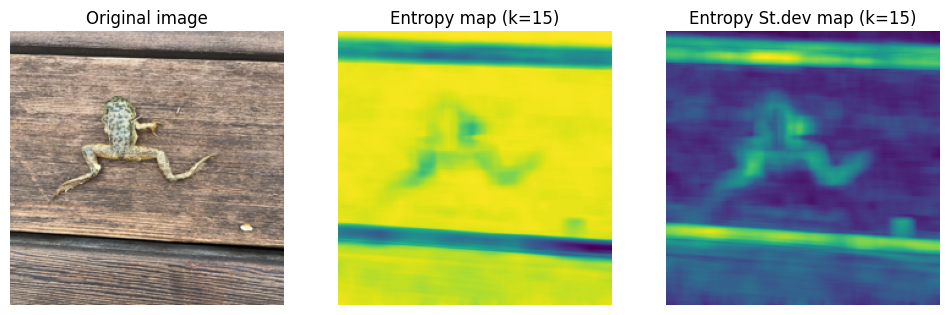

In [ ]:
imagename = "frog.jpg"
orig = Image.open(imagename).convert("RGB").resize((224,224))
img  = ttf.to_tensor(orig.convert("L"))

k = 15

# pooling module
#ep = EntropyPool2d(kernel_size = k).to(DEVICE)
#emap = ep(img)

emap = e_pooling(img, k)

# std map
stdmap = entropy_pooling(img, k = k, fun = torch.std)

# plotting
fig, axs = plt.subplots(1,3,figsize=(12,8))

axs[0].imshow(orig)
axs[0].set_title("Original image")
axs[0].axis("off")
axs[1].imshow(emap[0,:,:])
axs[1].set_title(f"Entropy map (k={k})")
axs[1].axis("off")
axs[2].imshow(stdmap[0,:,:])
axs[2].set_title(f"Entropy St.dev map (k={k})")
axs[2].axis("off")
plt.show()

In [ ]:
# precompute the entropy map for a grid of kernel sizes
tosave = dict()
ks = [3, 7, 11, 21, 31]
for k in ks:
    emap = e_pooling(img, k)
    s = entropy_pooling(img, k=k, fun=torch.std)
    tosave[k] = (emap,s)

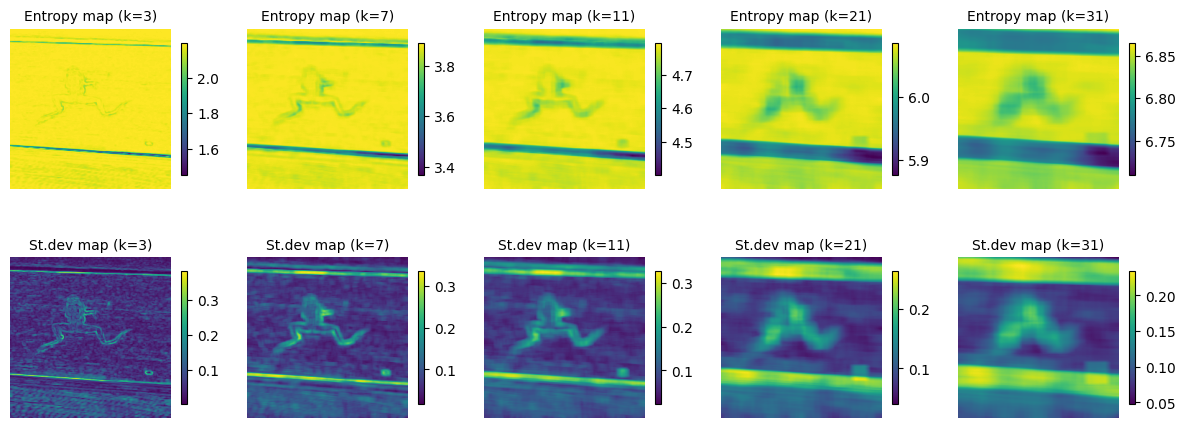

In [ ]:
# plot
fig, axs = plt.subplots(2, 5, figsize=(12,5))
for i, ax in enumerate(axs.flatten()):
    if i < 5:
        mat = ax.imshow(tosave[ks[i]][0][0,:,:])
        ax.set_title(f"Entropy map (k={ks[i]})", fontsize=10)

    else:
        mat = ax.imshow(tosave[ks[i-5]][1][0,:,:])
        ax.set_title(f"St.dev map (k={ks[i-5]})", fontsize=10)

    ax.axis("off")
    cbar = fig.colorbar(mat, ax = ax, shrink=0.55)

plt.tight_layout()
plt.show()

This cell below as a backup in order to compute any pooling operation with a custom function implementing folding and unfolding of a given matrix.
It needs to be optimised since the pooling coputation is performed via python map before unfolding into the original matrix.

### Frequency filtering


Here the complete CMA-ES block evolving cropping regions is implemented

In [12]:
class FrequencyPass():
    def __init__(self, h:int, w:int, s:int, freq:str):
        self.h, self.w, self.s = h, w, s
        self.freq = freq

    def _freq_mask(self):
        # find conditions over the x axis
        xc = np.where(abs(np.arange(0, self.w)-(self.w/2)) <= self.s/2, 1, 0)\
            if self.freq=="low" \
            else np.where(abs(np.arange(0, self.w)-(self.w/2))\
                <= (min(self.h,self.w)-self.s)/2, 0, 1)
        # find conditions over the y axis
        yc = np.where(abs(np.arange(0, self.h)-(self.h/2)) <= self.s/2, 1, 0)\
            if self.freq=="low" \
            else np.where(abs(np.arange(0, self.h)-(self.h/2))\
                <= (min(self.h,self.w)-self.s)/2, 0, 1)
        return yc.reshape((yc.shape[0],1)).dot(xc.reshape((1,xc.shape[0])))

    def filter(self, img):
        return torch.tensor(abs(np.fft.ifft2(np.multiply(
            self._freq_mask(self.h, self.w, self.s, self.freq),
            np.fft.fftshift(np.fft.fft2(img))
        )))).unsqueeze(0)

# functional implementation
#def freq_filter(img, h,w,s,freq):
#    fp = FrequencyPass(h, w, s, freq)
#    return fp.filter(img)
### try the functional version (not sure it would be better, just more elegant)

def freq_mask(h,w,s, freq="low"):
    """
    Compute mask estimation according to either "low" or "high"
    frequency pass.
    Args:
        h,w: (int) hight and width image size
        s: (int) filter threshold
        freq: (str) "low" or "high" filter
    Return:
        torch.Tensor binary mask
    """
    xc = np.where(abs(np.arange(0, w)-(w/2)) <= s/2, 1, 0)  if freq=="low" \
        else  np.where(abs(np.arange(0, w)-(w/2)) <= (min(h,w)-s)/2, 0, 1)
    yc = np.where(abs(np.arange(0, h)-(h/2)) <= s/2, 1, 0)  if freq=="low" \
        else  np.where(abs(np.arange(0, h)-(h/2)) <= (min(h,w)-s)/2, 0, 1)
    return yc.reshape((yc.shape[0],1)).dot(xc.reshape((1,xc.shape[0])))

def freq_filter(img, h,w,s, freq="low"):
    """
    Return the preprocessed frequency map image according to either
    "low" or "high" frequency pass.
    Args:
        img: (torch.tensor) input image
        h,w: (int) hight and width image size
        s: (int) filter threshold
        freq: (str) "low" or "high" filter
    Return:
        torch.Tensor
    """
    return torch.tensor(abs(np.fft.ifft2(np.multiply(freq_mask(h,w,s,freq),
                                                    np.fft.fftshift(np.fft.fft2(img))
                                                    )))).unsqueeze(0)

In [178]:
imgfilename = "imageneta.png"
h,w = (224,224)
orig = Image.open(imgfilename).convert("RGB").resize((h,w))
img  = Image.open(imgfilename).convert("L").resize((h,w))
ftransformed = np.fft.fftshift(np.fft.fft2(img))
inv_ftrasformed = np.fft.ifft2(ftransformed)

# plotting
fig, axs = plt.subplots(1,2,figsize=(10,7))
axs[0].imshow(orig)
axs[0].set_title("Original image")
axs[0].axis("off")
axs[1].imshow(np.log(abs(ftransformed)), cmap='gray')
axs[1].set_title("Discrete Fourier Transform")
axs[1].axis("off")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'imageneta.png'

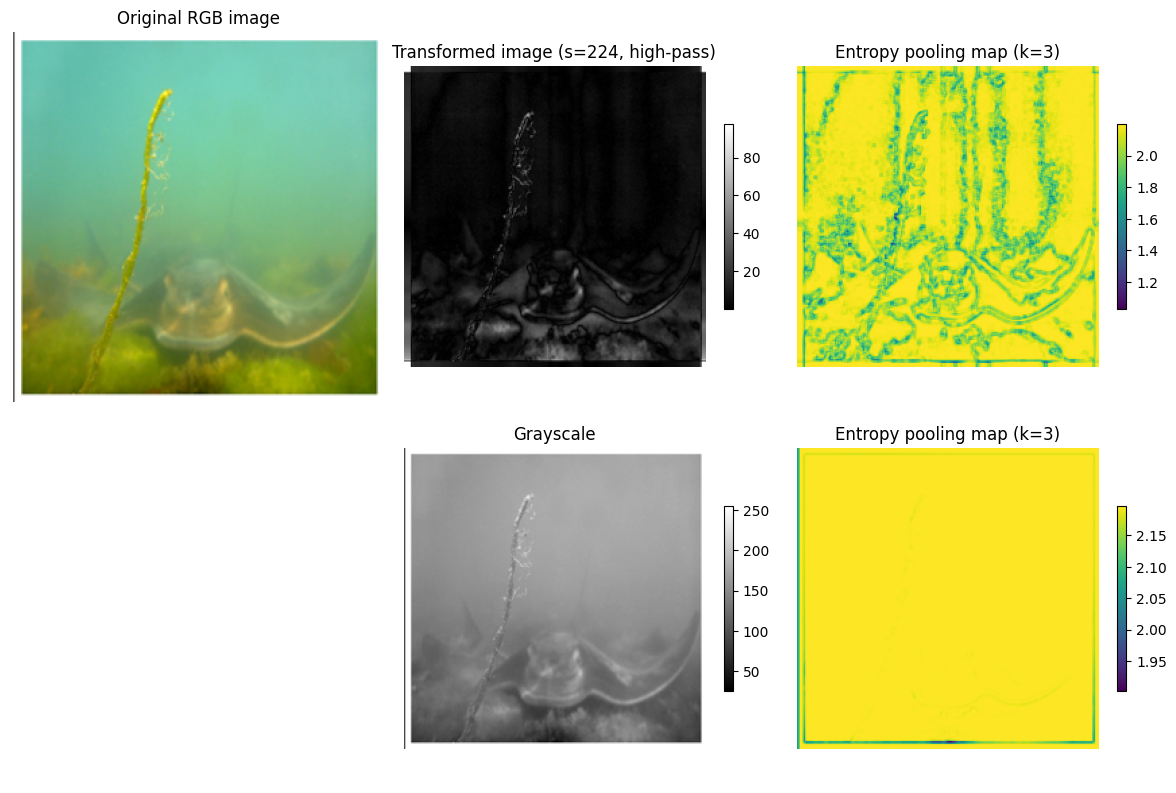

In [ ]:
# Hyperparameters definition
factor = 1            # how much s needs to be reweighted (0=none,1=full)
s      = h * factor   # freq filter size
k      = 3           # entropy pooling kernel size
freq   = "high"       # "low" or "high" pass filtering

freq_filt_img = freq_filter(img, h, w, s, freq)
ep = EntropyPool2d(kernel_size=k).to(DEVICE)

entropy_img_frmap = ep(freq_filt_img)

try:
    entropy_img_map   = ep(ttf.to_tensor(img))
except:
    entropy_img_map   = entropy_pooling(ttf.to_tensor(img), k=k)

fig, axs = plt.subplots(2 , 3, figsize=(12,8))
axs[0][0].imshow(orig)
axs[0][0].set_title("Original RGB image", fontsize=12)
axs[0][0].axis("off")

m1 = axs[0][1].imshow(freq_filt_img[0,:,:], cmap="gray")
axs[0][1].set_title(f"Transformed image (s={round(s)}, {freq}-pass)", fontsize=12)
axs[0][1].axis("off")
cbar = fig.colorbar(m1, ax = axs[0][1], shrink=0.5)

m2 = axs[0][2].imshow(entropy_img_frmap[0,:,:])
axs[0][2].set_title(f"Entropy pooling map (k={k})", fontsize=12)
axs[0][2].axis("off")
cbar = fig.colorbar(m2, ax = axs[0][2], shrink=0.5)

#axs[1][0].imshow(orig)
#axs[3].set_title("Original image", fontsize=10)
axs[1][0].axis("off")

m4 = axs[1][1].imshow(img, cmap="gray")
axs[1][1].set_title(f"Grayscale", fontsize=12)
axs[1][1].axis("off")
cbar = fig.colorbar(m4, ax = axs[1][1], shrink=0.5)

m5 = axs[1][2].imshow(entropy_img_map[0,:,:])
axs[1][2].set_title(f"Entropy pooling map (k={k})", fontsize=12)
axs[1][2].axis("off")
cbar = fig.colorbar(m5, ax = axs[1][2], shrink=0.5)

plt.tight_layout()
plt.show()

### CMA-ES
*(Covariance Matrix Adaptation - Evolutionary Strategy)*


In [13]:
class CropInstance():
	"""
	Normalised Crop instance (region proposal) over a given target image
	"""
	def __init__(self, x:float, y:float, w:float, h:float, imgsize:tuple):
		assert 0 <= x < 1 and 0 <= y < 1, "Cropping point out of bound!"
		assert 0 <= w <= 1 and 0 <= h <= 1, "Bounding dimension out of bound!"
		self.x = x
		self.y = y
		self.w = w
		self.h = h
		self.imgsize = imgsize
		self.xlim, self.ylim = 1, 1
		self.w_min, self.h_min = 1/6, 1/6  # or even 1/5

		# check for min/max bounds
		self.w = self.w if self.w > self.w_min else self.w_min
		self.x = self.xlim - self.w if self.x + self.w > self.xlim else self.x
		self.h = self.h if self.h > self.h_min else self.h_min
		self.y = self.ylim - self.h if self.y + self.h > self.ylim else self.y

		# final check: consider to delete this section
		assert self.x + self.w <= self.xlim, "Cropping bounding box out of bound! (x axis)"
		assert self.y + self.h <= self.ylim, "Cropping bounding box out of bound! (y axis)"

		# integer conversion
		self.xint, self.yint, self.wint, self.hint = tuple(
			map(round,
			    [self.x * self.imgsize[0],
				 self.y * self.imgsize[1],
				 self.w * self.imgsize[0],
				 self.h * self.imgsize[1]]
				) # need to reverse the 0,1 since is (h,w) and not (w,h) (as long as it's squared it's ok)
   			)
	def __str__(self):
		return  "-------------------- (x)    (y)    (w)    (h)\n"+\
			   f"fixed coords:  float: {self.x:.4f} {self.y:.4f} {self.w:.4f} {self.h:.4f}\n"+\
			   f"               int  : {(self.xint, self.yint, self.wint, self.hint)}"

In [ ]:
ci = CropInstance(0.90, 0.95, 0.1, 0.001, (224,224))
print(ci)

-------------------- (x)    (y)    (w)    (h)
fixed coords:  float: 0.8333 0.8333 0.1667 0.1667
               int  : (187, 187, 37, 37)


### Augmenter

In [15]:
def get_augmenter():
    """ Return AutoAugmenter policy pre-optimized over IMAGENET
    """
    return v2.Compose([
        v2.AutoAugment(v2.AutoAugmentPolicy.IMAGENET),
        v2.RandomHorizontalFlip(p=0.5),
    ]).to(DEVICE)

Displaying *Autoaugmentation* examples as in [REFERENCE] explain the RL-based augmentation search learned over the ImageNet dataset.
Specify that if you want to be really out-of-the-box the augmentation policy needs to be tuned differently: since it may be biased with respect to the original dataset on which it had been originally implemented.

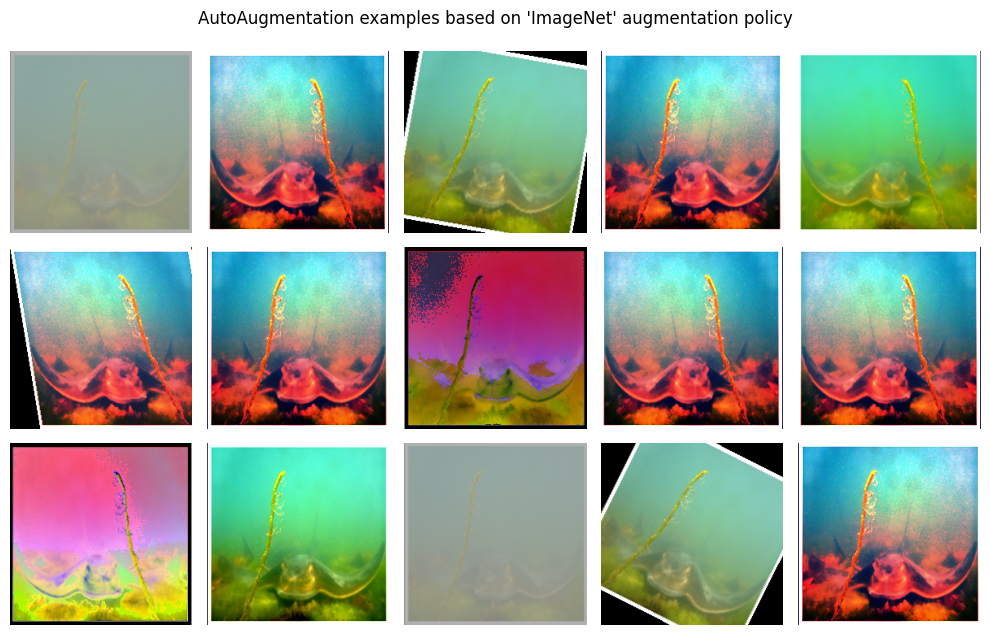

In [ ]:
img = Image.open("imageneta.png").convert("RGB").resize((224,224))
augmenter = get_augmenter()

fig, axs = plt.subplots(3,5, figsize=(10,6.5))
for i, ax in enumerate(axs.flatten()):
    ax.imshow((augmenter(img)))
    ax.axis("off")

plt.suptitle("AutoAugmentation examples based on 'ImageNet' augmentation policy")
plt.tight_layout()
plt.show()

### Load and testing Super Resolution model


In [16]:
# clone repo
if not os.path.exists("SwinIR"):
    !git clone https://github.com/JingyunLiang/SwinIR.git

# load pretrained model params
if not os.path.exists("experiments"):
    !wget https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x4_GAN.pth -P experiments/pretrained_models

Cloning into 'SwinIR'...
remote: Enumerating objects: 333, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 333 (delta 6), reused 5 (delta 2), pack-reused 320
Receiving objects: 100% (333/333), 29.84 MiB | 14.14 MiB/s, done.
Resolving deltas: 100% (119/119), done.
--2024-06-13 07:30:29--  https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x4_GAN.pth
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://objects.githubusercontent.com/github-production-release-asset-2e65be/396770997/f3c0fbd1-d787-49f1-924a-8939e9a6707c?X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Credential=releaseassetproduction%2F20240613%2Fus-east-1%2Fs3%2Faws4_request&X-Amz-Date=20240613T073029Z&X-Amz-Expires=300&X-Amz-Signature=3d8e4ef3f7a1851ecde88ba7126f8dd267bef84d9e4f6751

In [17]:
from SwinIR.models.network_swinir import SwinIR as net

def get_sr_model():
    """ Return SR model
    """
    # state dict specification
    param_key_g = 'params_ema'
    model = net(upscale=4, in_chans=3, img_size=64, window_size=8,
                img_range=1., depths=[6, 6, 6, 6, 6, 6],
                embed_dim=180, num_heads=[6, 6, 6, 6, 6, 6],
                mlp_ratio=2, upsampler='nearest+conv', resi_connection='1conv')
    model = model.to(DEVICE)
    pretrained_model = torch.load("experiments/pretrained_models/003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x4_GAN.pth")
    model.load_state_dict(pretrained_model[param_key_g] if param_key_g in pretrained_model.keys() else pretrained_model, strict=True)
    return model


def sr_run(lr_image, model, sf, tile, overlap, verbose=True):
    """ Adapted from https://github.com/JingyunLiang/SwinIR/blob/main/main_test_swinir.py
    Args:
        lr_image: (PIL image) low resolution image to be upscaled
        model: (torch.nn.Module) super resolution model
        sf: (int) scale factor, (default: 4)
        tile: (int) tile size while splitting the SR run (default: 32, 64)
        overlap: (int) pixel overlap
    Return:
        sr_image (torch.Tensor) dims: (1, c, h, w)
    """
    lr_image = ttf.to_tensor(lr_image).unsqueeze(0) if not type(lr_image)==torch.Tensor else lr_image

    print(f"    LR image size: {lr_image.shape}", end=" ") if verbose else None

    model.eval()

    b, c, h, w = lr_image.size()

    fullImagePass = True if min(h, w) <= tile else False

    # test the image without tiling
    if fullImagePass:
        print(" - full pass LR image") if verbose else None
        with torch.no_grad():
            sr_image = model(lr_image.to(DEVICE))

    # unfold and process the image tile by tile
    else:
        if verbose:
            print(" - Unfolding LR image...")
        assert tile < min(h,w), "Tile must be less than imagesize (h,w) "
        stride = tile - overlap
        h_ids = [i for i in range(0, h - tile, stride)]
        w_ids = [j for j in range(0, w - tile, stride)]
        h_ids.append(h - tile)
        w_ids.append(w - tile)
        h_idx_list = list(range(0, h - tile, stride)) + [h - tile]
        w_idx_list = list(range(0, w - tile, stride)) + [w - tile]

        # Init output of zeros
        E = torch.zeros(b, c, h * sf, w * sf).type_as(lr_image)
        W = torch.zeros_like(E)

        # Unfold and perform sr over patches
        for h_id in h_ids:
            for w_id in w_ids:
                in_patch = lr_image[..., h_id : h_id+tile, w_id : w_id+tile]

                with torch.no_grad():
                    out_patch = model(in_patch.to(DEVICE))

                out_patch = out_patch.to("cpu")
                out_patch_mask = torch.ones_like(out_patch)
                E[..., h_id*sf:(h_id+tile)*sf, w_id*sf:(w_id+tile)*sf].add_(out_patch)
                W[..., h_id*sf:(h_id+tile)*sf, w_id*sf:(w_id+tile)*sf].add_(out_patch_mask)
        sr_image = E.div_(W)

    return sr_image

In [ ]:
# select image:
x = ttf.to_tensor(Image.open("frog.jpg").convert("RGB").resize((56,56))).unsqueeze(0)

x = x.to(DEVICE)
srmodel = get_sr_model()
#sr = sr_run(x, srmodel, sf=4, tile=32, overlap=4)

#print("input:  ",x.shape)
#print("output: ",sr.shape)

  LR image size: torch.Size([1, 3, 56, 56])  - Unfolding LR image...
input:   torch.Size([1, 3, 56, 56])
output:  torch.Size([1, 3, 224, 224])


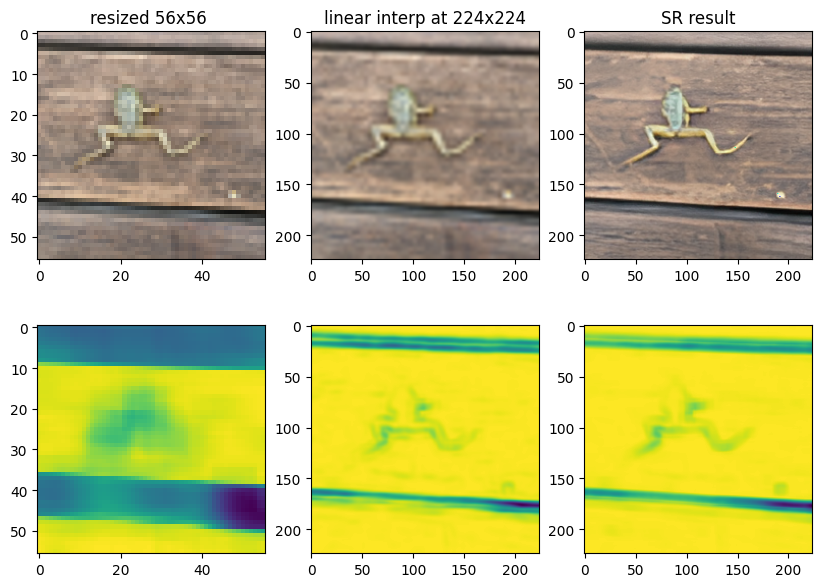

In [ ]:
kernel_size = 11

fig, ax = plt.subplots(2,3,figsize=(10,7))

ax[0,0].imshow(ttf.to_pil_image(x.squeeze(0)))
ax[0,0].set_title("resized 56x56 ")
ax[0,1].imshow(ttf.to_pil_image(x.squeeze(0)).resize((224,224)))
ax[0,1].set_title("linear interp at 224x224")
ax[0,2].imshow(ttf.to_pil_image(sr.squeeze(0)))
ax[0,2].set_title("SR result")

ax[1,0].imshow(e_pooling(ttf.to_tensor(ttf.to_pil_image(x.squeeze(0)).convert("L")), kernel_size).squeeze(0))
ax[1,1].imshow(e_pooling(ttf.to_tensor(ttf.to_pil_image(x.squeeze(0)).resize((224,224)).convert("L")), kernel_size).squeeze(0))
ax[1,2].imshow(e_pooling(ttf.to_tensor(ttf.to_pil_image(sr.squeeze(0)).convert("L")), kernel_size).squeeze(0))

plt.show()

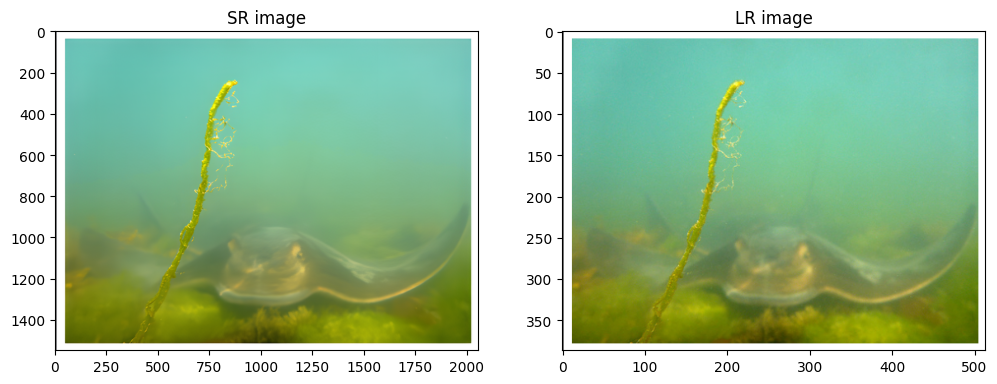

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(12,8))
axs[0].imshow(Image.open("results/swinir_real_sr_x4/imageneta_SwinIR.png"))
axs[0].set_title("SR image")
axs[1].imshow(Image.open("imageneta.png"))
axs[1].set_title("LR image")
plt.show()

### Optimizer definition according to backbone

Each backbone had been tested via a specific optimizer. Namely:
- `ResNet50`: Stocastic Gradient Descent (`lr = 0.00025`, `weight_decay = 0.0`)
- `RVT*-small`, `ResNet101` (and `ViT`): AdamW (`lr = 0.00001`, `weight_decay = 0.01`)

In [18]:
def get_optimizer(backbonename, model):
    """ Return the optimizer used as in reference paper according to backbone
    """
    if backbonename == "resnet":
        optimizer = torch.optim.SGD(model.parameters(), lr=0.00025, weight_decay=0.0)
    elif backbonename in ("resnet101", "vit", "rvt"):
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001, weight_decay=0.01)
    return optimizer

### Download Grounding DINO

In [20]:
import os
import supervision as sv

HOME = os.getcwd()

# download and configure repo
os.system(f"""
    git clone https://github.com/IDEA-Research/GroundingDINO.git; \
    cd {HOME}/GroundingDINO; \
    pip install -q -e . \
    pip install roboflow
    """)

# download pretrained model params
os.system(f"""
    mkdir {HOME}/weights; \
    cd {HOME}/weights; \
    wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
    """)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.0/124.0 kB 3.9 MB/s eta 0:00:00


0

In [27]:
# path config
CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
WEIGHTS_NAME = "groundingdino_swint_ogc.pth"
WEIGHTS_PATH = os.path.join(HOME, "weights", WEIGHTS_NAME)

# load grounding model
%cd {HOME}/GroundingDINO
from groundingdino.util.inference import load_model, predict, annotate

def load_groundingDINO():
    return load_model(CONFIG_PATH, WEIGHTS_PATH)

/content/GroundingDINO


final text_encoder_type: bert-base-uncased


SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


Elapsed:  0.33290719985961914


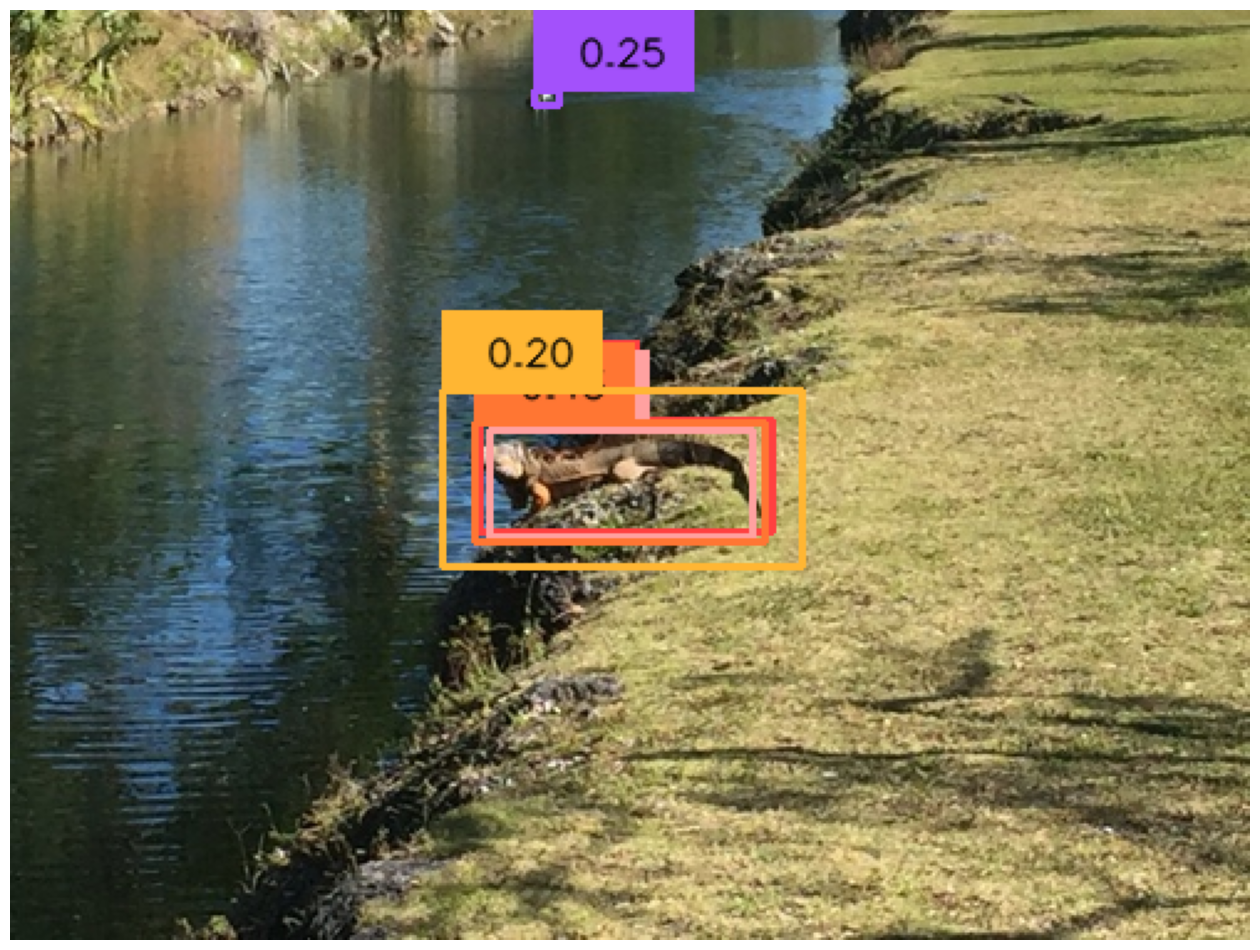

tensor([[0.4332, 0.0941, 0.0197, 0.0172],
        [0.4966, 0.5006, 0.2360, 0.1190],
        [0.4934, 0.5095, 0.2117, 0.1137],
        [0.4924, 0.5088, 0.2340, 0.1276],
        [0.4939, 0.5042, 0.2900, 0.1897]])
tensor([0.2496, 0.2678, 0.2382, 0.4332, 0.2049])


In [176]:
#GDINO demo
import os
import numpy as np
import torchvision.transforms.functional as ttf
import torchvision.transforms.v2 as v2
from PIL import Image


# adapted from https://github.com/IDEA-Research/GroundingDINO.git
def load_image(image_path: str):
    transform = v2.Compose([
         v2.Resize((224,224)),
         v2.ToTensor(),
         v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
    image_source = Image.open(image_path).convert("RGB")
    image = np.asarray(image_source)
    image_transformed, _ = transform(image_source, None)
    return image, image_transformed

IMAGE_NAME = "alligator.jpg"
IMAGE_PATH = os.path.join(HOME, IMAGE_NAME)

TEXT_PROMPT = "animal . bird . mammals . objects . reptile ." # hparams
BOX_TRESHOLD = 0.2 # hparams
TEXT_TRESHOLD = 0.5 # hparams

# one image at a time; batch processing is not supported (yet)
image_source, image = load_image(IMAGE_PATH)

model = load_groundingDINO()

import time
t0 = time.time()
boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)
t1 = time.time()
print("Elapsed: ", t1-t0)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))
print(boxes)
print(logits)

## Testing the learning procedure

[(94.8175, 19.159445, 4.4201202, 3.8531532), (84.80162, 98.8115, 52.867218, 26.658127), (86.82511, 101.40191, 47.41018, 25.4702), (84.08951, 99.68089, 52.420593, 28.593338), (78.156, 91.69901, 64.964455, 42.48983)]


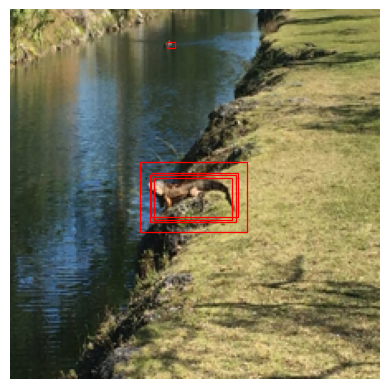

In [177]:
w, h = (224,224)

# percentage
xywh_perc = box_convert(boxes = boxes, in_fmt="cxcywh", out_fmt="xywh").numpy()

# back into xywh format integer
xywh = box_convert(boxes = boxes * torch.Tensor([w, h, w, h]),
                   in_fmt="cxcywh", out_fmt="xywh").numpy()

detections_perc = sv.Detections(xyxy = xywh_perc)
detections = sv.Detections(xyxy = xywh)

bbperc = [tuple(xywh_perc[i,j] for j in range(xywh_perc.shape[-1]))\
          for i in range(xywh_perc.shape[0])]
bbint  = [tuple(xywh[i,j] for j in range(xywh.shape[-1]))\
          for i in range(xywh.shape[0])]
print(bbint)

#bbint  = [tuple([detections[j].xyxy[:, i][0]\
#                 for i in range(detections[j].xyxy.shape[-1])])\
#            for j in range(len(detections))]


fig, ax = plt.subplots(1,1)
ax.imshow(ttf.to_pil_image(image_source).resize((224,224)))
for x,y,w,h in bbint:
    ax.add_patch(
            patches.Rectangle((x, y),
                                w, h,
                                linewidth=0.9,
                                edgecolor='r',
                                facecolor='none'))
plt.axis("off")
plt.show()

### S3 bucket implementation


In [ ]:
class S3ImageFolder(torch.utils.data.Dataset):
    def __init__(self, root, folder_to_labels, transform=None):
        self.s3_bucket = "deeplearning2024-datasets"
        self.s3_region = "eu-west-1"
        self.s3_client = boto3.client("s3", region_name=self.s3_region, verify=True)
        self.transform = transform
        self.folder_to_labels = folder_to_labels

        # Get list of objects in the bucket
        response = self.s3_client.list_objects_v2(Bucket=self.s3_bucket, Prefix=root)
        objects = response.get("Contents", [])
        while response.get("NextContinuationToken"):
            response = self.s3_client.list_objects_v2(
                Bucket=self.s3_bucket,
                Prefix=root,
                ContinuationToken=response["NextContinuationToken"])
            objects.extend(response.get("Contents", []))

        # Iterate and keep valid files only
        self.instances = []
        for ds_idx, item in enumerate(objects):
            key = item["Key"]
            path = Path(key)

            # Check if file is valid
            if path.suffix.lower() not in (".jpg", ".jpeg", ".png", ".ppm",
                ".bmp", ".pgm", ".tif", ".tiff", ".webp"):
                continue

            # Get label
            label = path.parent.name

            # Keep track of valid instances
            self.instances.append((label, key))

        # Sort classes in alphabetical order (as in ImageFolder)
        self.classes = sorted(set(label for label, _ in self.instances))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

    def __len__(self):
        return len(self.instances)

    def __getitem__(self, idx):
        try:
            foldername, key = self.instances[idx]

            # folder name to label conversion
            label = self.folder_to_labels[foldername]

            # Download image from S3
            response = self.s3_client.get_object(Bucket=self.s3_bucket, Key=key)
            img_bytes = response["Body"]._raw_stream.data

            img_bytes = BytesIO()
            response = self.s3_client.download_fileobj(Bucket=self.s3_bucket,
                                                       Key=key, Fileobj=img_bytes)
            #img_bytes = response["Body"]._raw_stream.data

            # Open image with PIL
            img = torchvision.transforms.functional.to_tensor(Image.open(img_bytes)\
                                                              .convert("RGB")\
                                                              .resize((224,224)))
            # Apply transformations if any
            if self.transform is not None:
                img = self.transform(img)

        except Exception as e:
            raise RuntimeError(f"Error loading image at index {idx}: {str(e)}")

        return img, label


def get_dataloader(batch_size, img_root, workers=1, transform=None):
    """ Return the imagenet-a dataloader instance """
    dataset = S3ImageFolder(root=img_root,
                            folder_to_labels=FOLDERS,
                            transform=transform)
    return torch.utils.data.DataLoader(dataset,
                                        batch_size=batch_size,
                                        shuffle=False,
                                        num_workers=workers)


### Re-implementation (Obj instances implementation)
Test it first

In [ ]:
import os
import csv
import time
import itertools

class EvoTTA(object):
    """ Structure that will manage the evolutionary search, augmentation
    and inference procedure by performing an "episodic" learning stage at
    inference time.
    """
    def __init__(self, image, label, backbonename, model, srmodel, hparams,
                 dino_hparams augmenter, loss_function, optimizer,
                 imgsize=(224,224), sr_ratio=0.33, n_classes=1000):

        self.image = image
        self.label = label
        self.backbonename = backbonename
        self.model = model
        self.srmodel = srmodel

        self.mode        = hparams["mode"]
        self.Ntrials     = hparams["Ntrials"]
        self.popSize     = hparams["popSize"]
        self.kernel_size = hparams["kernel_size"]
        self.enableSR    = hparams["enableSR"]
        self.enableAugm  = hparams["enableAugm"]

        self.prompt   = dino_hparams["prompt"]
        self.text_thr = dino_hparams["text_thr"]
        self.box_thr  = dino_hparams["box_thr"]

        self.augmenter     = augmenter
        self.loss_function = loss_function
        self.optimizer     = optimizer
        self.imgsize       = imgsize
        self.sr_ratio      = sr_ratio

        self.cache = dict()
        self.n_classes = n_classes

    #-------------------------------------------------------------------------------
    # *** General class utility functions
    #-------------------------------------------------------------------------------

    def init_cache(self):
        """ Cache initialzion storing evo-derived region proposal performance
        """
        if self.cache == dict():
            self.cache = {"best_fit":np.zeros((self.Ntrials)),
                         "avg_fit":np.zeros((self.Ntrials)),
                         "std_fit":np.zeros((self.Ntrials)),
                         "median_fit":np.zeros((self.Ntrials)),
                         "worst_fit":np.zeros((self.Ntrials)),
                         "cand_solutions":[],
                         "best_solutions":[],
                         }

    def update_cache(self, generation, value, phenotype):
        """ Update the optimization performance logs
        """
        self.cache["best_fit"][generation] = torch.min(value).item()
        self.cache["avg_fit"][generation] = torch.mean(value).item()
        self.cache["std_fit"][generation] = torch.std(value).item()
        self.cache["median_fit"][generation] = torch.median(value).item()
        self.cache["worst_fit"][generation] = torch.max(value).item()
        self.cache["cand_solutions"].append(phenotype)
        self.cache["best_solutions"].append(phenotype[torch.argmin(value).item()])

    def plot_performance(self):
        """ Plot fitness values along generations
        """
        plt.figure(figsize=(10,5))
        plt.plot(self.cache["best_fit"],\
            color="green", label="best", linewidth=0.9, alpha=0.5, linestyle="dashed")
        plt.plot(self.cache["worst_fit"],\
            color="red", label="worst", linewidth=0.9, alpha=0.5, linestyle="dashed")
        plt.plot(self.cache["median_fit"],\
            color="black", label="median", linewidth=1.15, alpha=0.3)
        plt.plot(self.cache["avg_fit"],\
            color="blue", label="avg", linewidth=1.15)
        plt.plot(self.cache["avg_fit"]+self.cache["std_fit"],\
            color="blue", linewidth=0.3, alpha=0.3)
        plt.plot(self.cache["avg_fit"]-self.cache["std_fit"],\
            color="blue", linewidth=0.3, alpha=0.3)
        plt.fill_between(range(0, self.Ntrials),\
            self.cache["avg_fit"]+self.cache["std_fit"],\
            self.cache["avg_fit"]-self.cache["std_fit"],\
            alpha=0.1)
        plt.suptitle("CMA-ES performance")
        plt.ylabel("Region proposal avg entropy")
        plt.xlabel("Generation")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

    def show_crop_results(self, img):
        """ Plot Cropping regions according to generations
        """
        gens = [1] + list(range(10, self.Ntrials+1, 10))
        fig, axs = plt.subplots(3, 3, figsize=(12,8))
        fig.suptitle(f"Cropping regions over generations (k={self.kernel_size})", fontsize=14)

        for i, ax in enumerate(axs.flatten()):
            try: ax.imshow(np.asarray(img))
            except: ax.imshow(ttf.to_pil_image(img))
            for cbb in self.cache["cand_solutions"][gens[i]-1]:
                ax.add_patch(
                    patches.Rectangle((cbb.xint, cbb.yint),
                                       cbb.wint, cbb.hint,
                                       linewidth=0.9,
                                       edgecolor='r',
                                       facecolor='none'))
            ax.axis("off")
            ax.set_title(f"Gen: {gens[i]}")
        plt.show()

    #-------------------------------------------------------------------------------
    # *** TTA utility functions:
    #-------------------------------------------------------------------------------

    @staticmethod
    def entropyModelFitness(model, batch):
        """ Compute entropy of the cropped images organised in batch (n_item, c, w, h)
        """
        batch = batch.to(DEVICE)

        model.eval()
        with torch.no_grad():
            outputs = model(batch)
            probs   = torch.softmax(outputs, -1)
            return (-1)*torch.sum(torch.multiply(probs, torch.log(probs)), axis = -1)

    @staticmethod
    def entropyMapFitness(phenotype, imgsize, alpha=0.001, epsilon=10**(-5)):
        """ Compute the fitness of a cropped entropy / frequency-entropy map
        by estimating the mean entropy value over the area, penalized by the
        region size (the higher the better).
        """
        h, w = phenotype.shape[1:]
        h_ref, w_ref = imgsize
        return phenotype.mean() + alpha * (1 / ((h/h_ref) * (w/w_ref) + epsilon))

    @staticmethod
    def get_fmap(img, kernel_size, verbose=False):
        """ Feature map estimation by performing entropy pooling over
        the baseimage.
        """
        t0 = time.time()

        try:
            img = img.to(DEVICE)
            fmap = e_pooling(img, kernel_size)
        except:
            fmap = entropy_pooling(img, kernel_size, fun=entropy)

        t1 = time.time()
        print("E-pooling elapsed: ", round(t1-t0, 3)) if verbose else None
        return fmap.to("cpu")

    @staticmethod
    def resize_crop(img, x, y, w, h, target_dim):
        """ Return the unsqueeze cropped and resized image converted into tensor
        """
        if target_dim != None:
            resized = ttf.to_tensor(ttf.crop(img, y, x, h, w)\
                .resize(target_dim))\
                .unsqueeze(0)
        else:
            resized = ttf.crop(img, y, x, h, w)
        return resized

    @staticmethod
    def into_batch(img, phenotype, sample, mode, imgsize):
        """ Return a batch of region proposal instances converted into tensor
        of size (nItems, nChannel, H, W)
         """
        if mode == "model":
            batch = torch.cat(phenotype, 0) # concat tensors whose dims are (1, c, h, w)

        elif mode in ("emap", "freqmap"):
            cand_bb = [CropInstance(s[0], s[1], s[2], s[3], imgsize)\
                        for s in sample]
            batch   = [EvoTTA.resize_crop(img, cbb.xint, cbb.yint, cbb.wint, cbb.hint, imgsize)\
                        for cbb in cand_bb]
            batch   = torch.cat(batch, 0)

        return batch

    @staticmethod
    def augment(augmenter, sample):
        """ Perform data augmentation via augmenter obj
        """
        return torch.cat([augmenter(s).unsqueeze(0) for s in sample], 0)

    @staticmethod
    def get_pred_label(cum_prob, nclass2label, how="avg"):
        """ Return the confidence of the predicted label at inference time according
        to either ('avg' or 'max') conditions
        Args:
            cum_prob: (torch.Tensor) of prediction confidence (n_epoch, n_istance, n_classes)
            nclass2label: (dict) object that maps class number to original Imagenet_1k class names
            how: (str) way to compute prediction ('max', 'avg')
        Return:
            class label, class number, confidence level
        """
        assert how in ("max", "avg"), "Options allowed: ('max', 'how')"
        if how == "max": # Remove
            raise NotImplementedError
            #confidence, class_n = cum_prob[-1,:,:].max().item(), cum_prob[-1,:,:].argmax().item()
        elif how == "avg":
            confidence = cum_prob[-1,:,:].mean(0).max().item()
            nclass = cum_prob[-1,:,:].mean(0).argmax().item()
            label = nclass2label[nclass]
        return label, nclass, confidence

    @staticmethod
    def sr_run(lr_image, srmodel, sf, tile, overlap, verbose=False):
        """ Adapted from https://github.com/JingyunLiang/SwinIR/blob/main/main_test_swinir.py
        Args:
            lr_image: (PIL image) low resolution image to be upscaled
            srmodel: (torch.nn.Module) superresolution model
            sf: (int) Scaling Factor, (default: 4)
            tile: (int) tile size while splitting the SR run (default: 128)
            overlap: (int) pixel overlap
        Return:
            sr_image (torch.Tensor) dims: (1, c, h, w)
        """
        lr_image = ttf.to_tensor(lr_image).unsqueeze(0) if not type(lr_image)==torch.Tensor else lr_image

        print(f"    LR image size: {lr_image.shape}", end=" ") if verbose else None

        srmodel.eval()

        b, c, h, w = lr_image.size()

        # (full image pass condition): test the image without unfolding in tiles
        if min(h, w) <= tile:
            print(" - Full pass LR image") if verbose else None
            with torch.no_grad():
                lr_image = lr_image.to(DEVICE)
                sr_image = srmodel(lr_image)

        # unfold and process test image by tiles
        else:
            assert tile < min(h,w), "Tile must be less than imagesize (h,w)."
            print(" - Unfolding LR image") if verbose else None
            stride = tile - overlap
            h_ids = [i for i in range(0, h - tile, stride)] + [h - tile]
            w_ids = [j for j in range(0, w - tile, stride)] + [w - tile]

            # Init output of zeros
            E = torch.zeros(b, c, h * sf, w * sf).type_as(lr_image)
            W = torch.zeros_like(E)

            # Unfold and perform sr over patches
            for h_id in h_ids:
                for w_id in w_ids:
                    in_patch = lr_image[..., h_id : h_id+tile, w_id : w_id+tile]
                    in_patch = in_patch.to(DEVICE)
                    with torch.no_grad():
                        out_patch = srmodel(in_patch)
                    out_patch = out_patch.to("cpu")
                    out_patch_mask = torch.ones_like(out_patch)
                    E[..., h_id*sf:(h_id+tile)*sf, w_id*sf:(w_id+tile)*sf].add_(out_patch)
                    W[..., h_id*sf:(h_id+tile)*sf, w_id*sf:(w_id+tile)*sf].add_(out_patch_mask)
            sr_image = E.div_(W)

        return sr_image

    #-------------------------------------------------------------------------------
    # *** TTA main functions:
    #-------------------------------------------------------------------------------

    def high_res(self, img, cand_bb, sf=4, tile=128, overlap=4):
        """ Trying first a simple approach that convert into a super res image according
        to a given criterion (individually, not in batch while performing the full pass)
        Args:
            img:
            cand_bb:
            ratio: (float) (default = 0.33)
        Return:
            batch (list) of sr_images rescaled by a scale factor of 4 (default)
        """
        batch = []
        h, w = self.imgsize

        for cbb in cand_bb:

            # check for minimum area elegibility
            if cbb.wint * cbb.hint <= (w*h) * self.sr_ratio:

                # region proposal extraction
                cropped = self.resize_crop(img, cbb.xint, cbb.yint, cbb.wint, cbb.hint, None)

                # performing upscaling
                cropped = self.sr_run(cropped, self.srmodel, sf, tile, overlap).squeeze(0)
                rescaled = ttf.to_tensor(ttf.to_pil_image(cropped).resize(self.imgsize)).unsqueeze(0)

            # rescaling to model size if region proposal area is > ratio
            else:
                rescaled = self.resize_crop(img, cbb.xint, cbb.yint, cbb.wint, cbb.hint, self.imgsize)

            batch.append(rescaled) # list of tensor (1, c, h, w)
        return batch


    def evolve(self, verbose=False, display=False):
        """ Perform augmentation search in order to crop test image areas by
        minimising the objective function according to the 'mode' ('model', 'emap',
        'freqmap') approach.

        Return:
            batch: torch.Tensor of dim (n_items, n_channel, h, w).
            solutions: (array) (solution_i, fitness_i) of the i-th evolved instance.
            cache: (dict) performance log.
        """
        self.init_cache()

        # preprocess test image and extract feature map if mode in ("emap", "freqmap")
        orig = ttf.to_pil_image(self.image.squeeze(0))

        if self.mode == "model":
            img = orig

        elif self.mode == "emap":
            img = ttf.to_tensor(ttf.resize(orig.convert("L"), self.imgsize))
            fmap = self.get_fmap(img=img,
                                 kernel_size=self.kernel_size)

        elif self.mode == "freqmap":
            img = ttf.resize(orig.convert("L"), self.imgsize)
            fmap = self.get_fmap(img=freq_filter(img, self.imgsize[0], self.imgsize[1], self.imgsize[1], freq="high"),
                                 kernel_size=self.kernel_size)

        # CMA-ES Optimizer "ask-and-tell"-style instance initialization
        # search space in 4 dimensions (bounding box x0, y0, h, w parameters)
        optimizer4d = CMA(mean = np.array([0.2, 0.2, 0.6, 0.6]),
                          sigma = 0.1,
                          bounds = np.array([(0,1), (0,1), (0,1), (0,1)]),
                          population_size = self.popSize,
                          seed = np.random.randint(0, 10**5),
                          lr_adapt=True)

        # evolving over generations
        for generation in range(self.Ntrials):

            # draw the current generation sample
            sample =  [optimizer4d.ask() for _ in range(optimizer4d.population_size)]

            # convert each candidate solution into a CropInstance bounding box
            cand_bb = [CropInstance(s[0], s[1], s[2], s[3], self.imgsize) for s in sample]

            # region proposal search by model prediction confidence
            if self.mode == "model":
                phenotype = self.high_res(img, cand_bb) if self.enableSR \
                            else [self.resize_crop(img, cbb.xint, cbb.yint, cbb.wint, cbb.hint, self.imgsize)\
                                  for cbb in cand_bb] # list of tensor (1, c, h, w) to be concatenate over axis 0
                batch = self.into_batch(orig, phenotype, sample, self.mode, self.imgsize)
                value = self.entropyModelFitness(self.model, batch)

            # region proposal search by low level visual information entropy minimization
            elif self.mode in ("emap", "freqmap"):
                phenotype = [self.resize_crop(fmap, cbb.xint, cbb.yint, cbb.wint, cbb.hint, None)\
                             for cbb in cand_bb]
                value = torch.tensor([self.entropyMapFitness(instance, self.imgsize).item()\
                             for instance in phenotype])

            # Eval and draw new solutions
            solutions = [(sample[i], value[i].item()) for i in range(len(sample))]
            optimizer4d.tell(solutions)

            # Update cache
            self.update_cache(generation, value, cand_bb)

            if verbose:
                if (generation+1) % 1 == 0 or generation == 0:
                    print(f"  gen: {generation+1:3d}/{self.Ntrials}  -"+
                          f"  best: {self.cache['best_fit'][generation]:.6f}  -"+
                          f"  avg: {self.cache['avg_fit'][generation]:.6f}")

        # Checking for upscaling in entropy map conditions
        if self.mode in ("emap", "freqmap"):
            #print("  Entropy map condition: SR of region proposal") if self.enableSR else None
            phenotype = self.high_res(orig, cand_bb) if self.enableSR else phenotype
            batch = self.into_batch(orig, phenotype, sample, self.mode, self.imgsize)

        # Displaying fitness optimization and crop results
        if display:
            self.plot_performance()
            if self.mode == "model":
                self.show_crop_results(self.image)
            elif self.mode in ("emap", "freqmap"):
                self.show_crop_results(fmap[0,:,:])

        return batch, cand_bb, solutions


    def zero_shot_detection(self):

        # Zero-shot bounding box prediction
        boxes, logits, _ = predict(model = self.dinomodel,
                                   image = self.image,
                                   caption = self.prompt,
                                   box_threshold = self.box_thr,
                                   text_threshold = self.text_thr)

        # Bounding box generation
        w, h = self.imgsize

        # percentage
        #xywh_perc = box_convert(boxes = boxes, in_fmt="cxcywh", out_fmt="xywh").numpy()
        #bbperc    = [tuple(xywh_perc[i,j] for j in range(xywh_perc.shape[-1]))\
        #            for i in range(xywh_perc.shape[0])]

        # back into xywh format integer
        xywh = box_convert(boxes = boxes * torch.Tensor([w, h, w, h]),
                    in_fmt="cxcywh", out_fmt="xywh").numpy()
        cbb  = [tuple(xywh[i,j] for j in range(xywh.shape[-1]))\
                    for i in range(xywh.shape[0])]

        # resize image according to bb and merge into batch
        batch = [EvoTTA.resize_crop(self.img, x, y, w, h, self.imgsize)\
                    for x, y, w, h in cbb]


        return torch.cat(batch, 0)


    def single_test_time_adaptation(self, trainIter=1, evoProposal=True, verbose=False):
        """ Perform prediction via TTA given a single test_image. Allows to perform
        region proposal by evolving image cropping instances by means of CMA-ES (set
        evoProposal)
        Args:
            trainIter: (int) amount of self-supervised training steps (default: 1)
            evoProposal: (bool) True for evo-derived region proposal, False otherwise
            verbose: (bool) display progress
        Return:
            final batch of images, cumulative confidence and loss
        """
        cum_loss = torch.zeros((trainIter+1))
        cum_prob = torch.zeros((trainIter+1, self.popSize, self.n_classes))

        # In order to reset back model state after training/inference
        state_dict = copy.deepcopy(self.model.state_dict())
        optim_dict = copy.deepcopy(self.optimizer.state_dict())

        # Allow model to be trained
        self.model.train()

        for epoch in range(0, trainIter):
            msgout = f"Now on epoch: {epoch+1}/{trainIter}" if epoch < trainIter else "Inference:"
            print(msgout) if verbose else None

            if evoProposal:
                batch, _, _, = self.evolve()
            else:
                batch = self.image.repeat(self.popSize, 1, 1, 1)

            batch = self.augment(self.augmenter, batch) if self.enableAugm else batch
            batch = batch.to(DEVICE)

            # Forward pass
            outputs = self.model(batch)

            # if backbone is Resnet logits need to be extracted:
            #outputs = outputs["logits"].to(DEVICE)\
            #    if self.backbonename == "resnet"\
            #    else outputs.to(DEVICE)

            outputs = outputs.to(DEVICE)

            # logits to probabilities
            probs = torch.softmax(outputs, -1)

            # averaging over instances
            avg_probs = probs.mean(axis=0)

            # Loss computation
            loss = self.loss_function(avg_probs)

            # Backward pass
            loss.backward()

            # Parameters update
            self.optimizer.step()

            # Gradients reset
            self.optimizer.zero_grad()

            # Saving logs
            cum_prob[epoch, :, :] = probs
            cum_loss[epoch] = loss.item()
            print(f"Current loss: {loss.item()}", end="\n"+str("-"*70)+"\n")\
                if verbose else None

        # "Episodic" TTA version (updating within each single test datapoint)
        self.model.eval()

        # Inference
        with torch.no_grad():

            # perform model feedforward pass
            outputs = self.model(batch)\
                if evoProposal\
                else self.model(self.image.unsqueeze(0).to(DEVICE))

            # if backbone is Resnet, logits need to be extracted:
            #outputs = outputs["logits"].to(DEVICE)\
            #    if self.backbonename == "resnet"\
            #    else outputs.to(DEVICE)

            outputs = outputs.to(DEVICE)

            # logits to probabilities
            probs = torch.softmax(outputs, -1)

            # averaging over instances
            avg_probs = probs.mean(axis=0)\
                if evoProposal\
                else probs

            # loss estimation
            inference_loss = self.loss_function(avg_probs)

            cum_prob[trainIter, :, :] = probs
            cum_loss[trainIter] = inference_loss.item()

            print(f"Final loss: {inference_loss.item()}", end="\n"+str("-"*70)+"\n")\
                if verbose else None

        # reset current model/optimizer params
        self.model.load_state_dict(state_dict)
        self.optimizer.load_state_dict(optim_dict)

        return batch, cum_prob, cum_loss


# The following class is supposed to manage the test data evaluation according to
# the proposed Evo TTA approach.

class EvalEvoTTA(object):

    def __init__(self, backbonename, model, srmodel, augmenter, loss_function,
                 optimizer, combinations, dataloader, nclass2label, label2label,
                 outfile):
        self.backbonename = backbonename
        self.model = model
        self.srmodel = srmodel
        self.augmenter = augmenter
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.combinations = combinations
        self.dataloader = dataloader
        self.outfile = outfile

        # maps
        self.nclass2label = nclass2label
        self.label2label  = label2label

        # amount of images
        self.n_tot = self.dataloader.__len__()


    @staticmethod
    def store_results(file, header, data):
        """ Save results in csv
        """
        if not os.path.exists(file):
            os.system(f"echo {header} > {file}")
        with open(file, "a", encoding="utf-8") as csvfile:
            writer = csv.writer(csvfile, delimiter=",", quotechar='|', quoting=csv.QUOTE_MINIMAL)
            writer.writerow(data)


    def run_single_hset(self, combination, evoProposal=True, trainIter=1, verbose=False):
        """ Perform TTA evaluation over the complete set of test data given
        a set of hyperparams
        """
        corr_pred, n_sample = 0.0, 0.0

        mode, Ntrial, popSize, kernel_size, enableSR, enableAugm = combination

        # build evoparams
        hparams = {
            "mode": mode, "Ntrials": Ntrial, "popSize": popSize,
            "kernel_size": kernel_size, "enableSR": enableSR,
            "enableAugm": enableAugm,
        }

        print("Now on:", hparams)

        t0 = time.time()

        dl = iter(self.dataloader)

        for idx in tqdm(range(self.n_tot)):
            image, true_label = dl.__next__()

        #for idx, (image, true_label) in tqdm(enumerate(self.dataloader)):
            #print(f"Progress: {round((idx/self.n_tot)*100, 3)}%")

            true_label = true_label[0]

            evoTTA = EvoTTA(
                image = image,
                label = true_label,
                backbonename = self.backbonename,
                model = self.model,
                srmodel = self.srmodel,
                hparams = hparams,
                augmenter = self.augmenter,
                loss_function = self.loss_function,
                optimizer = self.optimizer,
                imgsize = (224,224),
            )

            batch, cum_prob, cum_loss = evoTTA.single_test_time_adaptation(trainIter, evoProposal, verbose=verbose)

            pred_label, pred_class_n, conf = evoTTA.get_pred_label(cum_prob, self.nclass2label, "avg")

            # label conversion to match those from the testdataset
            pred_label = self.label2label[pred_label]
            corr_pred = corr_pred + 1 if true_label == pred_label else corr_pred
            n_sample += 1

            print(f"Pred label: {pred_label}\nTrue label: {true_label}") if verbose else None
            print(f"Accuracy: {corr_pred/n_sample}", end="\n"+str("-"*70)+"\n") if verbose else None

        t1 = time.time()
        elapsed = round(t1-t0, 4)

        accuracy_top1 = corr_pred / n_sample
        error = 1 - accuracy_top1

        print("error:", error) # remove this line

        # storing result in a csv
        header = "'backbone,mode,Ntrials,popSize,kernel_size,enableSR,enableAugm,trainIter,errorRate,time'"
        if evoProposal:
            data = [self.backbonename, hparams["mode"], hparams["Ntrials"],
                    hparams["popSize"], hparams["kernel_size"], hparams["enableSR"],
                    hparams["enableAugm"], trainIter, error, elapsed]
        else:
            data = [self.backbonename, None, None, hparams["popSize"],
                    None, hparams["enableSR"], hparams["enableAugm"],
                    trainIter, error, elapsed]

        self.store_results(self.outfile, header, data)

        return error


    def run_all_hset(self, evoProposal=True, trainIter=1):
        """ Run all """
        for combination in self.combinations:
            self.run_single_hset(combination, evoProposal, trainIter)


In [ ]:
#!echo 'backbone,mode,Ntrials,popSize,kernel_size,enableSR,enableAugm,trainIter,errorRate,time' > finaleval_results.csv
#!echo 'resnet,,,8,,False,True,1,0.9961333333333333' >> finaleval_results.csv

### Re-implementing (Past and stable implementation that works)

In [ ]:
import os
import csv
import time
import itertools

class EvoTTA(object):
    """ Structure that will manage the evolutionary search, augmentation
    and inference procedure by performing an "episodic" learning stage at
    inference time.
    """
    def __init__(self, image, label, backbonename, model, srmodel, hparams,
        augmenter, loss_function, optimizer, imgsize=(224,224),
        sr_ratio=0.33, n_classes=1000):

        self.image = image
        self.label = label
        self.backbonename = backbonename
        self.model = model
        self.srmodel = srmodel

        self.mode        = hparams["mode"]
        self.Ntrials     = hparams["Ntrials"]
        self.popSize     = hparams["popSize"]
        self.kernel_size = hparams["kernel_size"]
        self.enableSR    = hparams["enableSR"]
        self.enableAugm  = hparams["enableAugm"]

        self.augmenter     = augmenter
        self.loss_function = loss_function
        self.optimizer     = optimizer
        self.imgsize       = imgsize
        self.sr_ratio      = sr_ratio

        self.h_sample, self.h_cand_bb, self.h_phenotype, self.h_solutions = [],[],[],[]

        self.cache = dict()
        self.n_classes = n_classes

    #-------------------------------------------------------------------------------
    # *** General class utility functions
    #-------------------------------------------------------------------------------

    def init_cache(self):
        """ Cache initialzion storing evo-derived region proposal performance
        """
        if self.cache == dict():
            self.cache = {"best_fit":np.zeros((self.Ntrials)),
                         "avg_fit":np.zeros((self.Ntrials)),
                         "std_fit":np.zeros((self.Ntrials)),
                         "median_fit":np.zeros((self.Ntrials)),
                         "worst_fit":np.zeros((self.Ntrials)),
                         "cand_solutions":[],
                         "best_solutions":[],
                         }

    def update_cache(self, generation, value, phenotype):
        """ Update the optimization performance logs
        """
        self.cache["best_fit"][generation] = torch.min(value).item()
        self.cache["avg_fit"][generation] = torch.mean(value).item()
        self.cache["std_fit"][generation] = torch.std(value).item()
        self.cache["median_fit"][generation] = torch.median(value).item()
        self.cache["worst_fit"][generation] = torch.max(value).item()
        self.cache["cand_solutions"].append(phenotype)
        self.cache["best_solutions"].append(phenotype[torch.argmin(value).item()])

    def plot_performance(self):
        """ Plot fitness values along generations
        """
        plt.figure(figsize=(10,5))
        plt.plot(self.cache["best_fit"],\
            color="green", label="best", linewidth=0.9, alpha=0.5, linestyle="dashed")
        plt.plot(self.cache["worst_fit"],\
            color="red", label="worst", linewidth=0.9, alpha=0.5, linestyle="dashed")
        plt.plot(self.cache["median_fit"],\
            color="black", label="median", linewidth=1.15, alpha=0.3)
        plt.plot(self.cache["avg_fit"],\
            color="blue", label="avg", linewidth=1.15)
        plt.plot(self.cache["avg_fit"]+self.cache["std_fit"],\
            color="blue", linewidth=0.3, alpha=0.3)
        plt.plot(self.cache["avg_fit"]-self.cache["std_fit"],\
            color="blue", linewidth=0.3, alpha=0.3)
        plt.fill_between(range(0, self.Ntrials),\
            self.cache["avg_fit"]+self.cache["std_fit"],\
            self.cache["avg_fit"]-self.cache["std_fit"],\
            alpha=0.1)
        plt.suptitle("CMA-ES performance")
        plt.ylabel("Region proposal avg entropy")
        plt.xlabel("Generation")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

    def show_crop_results(self):
        """ Plot Cropping regions according to generations
        """
        gens = [1] + list(range(10, self.Ntrials+1, 10))
        fig, axs = plt.subplots(3, 3, figsize=(12,8))
        fig.suptitle(f"Cropping regions over generations (k={self.kernel_size})", fontsize=14)

        for i, ax in enumerate(axs.flatten()):
            ax.imshow(np.asarray(self.image))
            for cbb in self.cache["cand_solutions"][gens[i]-1]:
                ax.add_patch(
                    patches.Rectangle((cbb.xint, cbb.yint),
                                       cbb.wint, cbb.hint,
                                       linewidth=0.9,
                                       edgecolor='r',
                                       facecolor='none'))
            ax.axis("off")
            ax.set_title(f"Gen: {gens[i]}")
        plt.show()

    #-------------------------------------------------------------------------------
    # *** TTA utility functions:
    #-------------------------------------------------------------------------------

    @staticmethod
    def entropyModelFitness(model, batch):
        """ Compute entropy of the cropped images organised in batch (n_item, c, w, h)
        """
        batch = batch.to(DEVICE)

        model.eval()
        with torch.no_grad():
            outputs = model(batch)
            probs   = torch.softmax(outputs, -1)
            return (-1)*torch.sum(torch.multiply(probs, torch.log(probs)), axis = -1)

    @staticmethod
    def entropyMapFitness(phenotype, imgsize, alpha=0.001, epsilon=10**(-5)):
        """ Compute the fitness of a cropped entropy / frequency-entropy map
        by estimating the mean entropy value over the area, penalized by the
        region size (the higher the better).
        """
        h, w = phenotype.shape[1:]
        h_ref, w_ref = imgsize
        return phenotype.mean() + alpha * (1 / ((h/h_ref) * (w/w_ref) + epsilon))

    @staticmethod
    def get_fmap(img, kernel_size, verbose=False):
        """ Feature map estimation by performing entropy pooling over
        the baseimage.
        """
        t0 = time.time()

        try:
            img = img.to(DEVICE)
            fmap = e_pooling(img, kernel_size)
        except:
            fmap = entropy_pooling(img, kernel_size, fun=entropy)

        t1 = time.time()
        print("E-pooling elapsed: ", round(t1-t0, 3)) if verbose else None
        return fmap.to("cpu")

    @staticmethod
    def resize_crop(img, x, y, w, h, target_dim):
        """ Return the unsqueeze cropped and resized image converted into tensor
        """
        if target_dim != None:
            resized = ttf.to_tensor(ttf.crop(img, y, x, h, w)\
                .resize(target_dim))\
                .unsqueeze(0)
        else:
            resized = ttf.crop(img, y, x, h, w)
        return resized

    @staticmethod
    def into_batch(img, phenotype, sample, mode, imgsize):
        """ Return a batch of region proposal instances converted into tensor
        of size (nItems, nChannel, H, W)
         """
        if mode == "model":
            batch = torch.cat(phenotype, 0) # concat tensors whose dims are (1, c, h, w)

        elif mode in ("emap", "freqmap"):
            cand_bb = [CropInstance(s[0], s[1], s[2], s[3], imgsize)\
                        for s in sample]
            batch   = [EvoTTA.resize_crop(img, cbb.xint, cbb.yint, cbb.wint, cbb.hint, imgsize)\
                        for cbb in cand_bb]
            batch   = torch.cat(batch, 0)

        return batch

    @staticmethod
    def augment(augmenter, sample):
        """ Perform data augmentation via augmenter obj
        """
        return torch.cat([augmenter(s).unsqueeze(0) for s in sample], 0)

    @staticmethod
    def get_pred_label(cum_prob, nclass2label, how="avg"):
        """ Return the confidence of the predicted label at inference time according
        to either ('avg' or 'max') conditions
        Args:
            cum_prob: (torch.Tensor) of prediction confidence (n_epoch, n_istance, n_classes)
            nclass2label: (dict) object that maps class number to original Imagenet_1k class names
            how: (str) way to compute prediction ('max', 'avg')
        Return:
            class label, class number, confidence level
        """
        assert how in ("max", "avg"), "Options allowed: ('max', 'how')"
        if how == "max": # Remove
            raise NotImplementedError
            #confidence, class_n = cum_prob[-1,:,:].max().item(), cum_prob[-1,:,:].argmax().item()
        elif how == "avg":
            confidence = cum_prob[-1,:,:].mean(0).max().item()
            nclass = cum_prob[-1,:,:].mean(0).argmax().item()
            label = nclass2label[nclass]
        return label, nclass, confidence

    @staticmethod
    def sr_run(lr_image, srmodel, sf, tile, overlap, verbose=False):
        """ Adapted from https://github.com/JingyunLiang/SwinIR/blob/main/main_test_swinir.py
        Args:
            lr_image: (PIL image) low resolution image to be upscaled
            srmodel: (torch.nn.Module) superresolution model
            sf: (int) Scaling Factor, (default: 4)
            tile: (int) tile size while splitting the SR run (default: 128)
            overlap: (int) pixel overlap
        Return:
            sr_image (torch.Tensor) dims: (1, c, h, w)
        """
        lr_image = ttf.to_tensor(lr_image).unsqueeze(0) if not type(lr_image)==torch.Tensor else lr_image

        print(f"    LR image size: {lr_image.shape}", end=" ") if verbose else None

        srmodel.eval()

        b, c, h, w = lr_image.size()

        # (full image pass condition): test the image without unfolding in tiles
        if min(h, w) <= tile:
            print(" - Full pass LR image") if verbose else None
            with torch.no_grad():
                lr_image = lr_image.to(DEVICE)
                sr_image = srmodel(lr_image)

        # unfold and process test image by tiles
        else:
            assert tile < min(h,w), "Tile must be less than imagesize (h,w)."
            print(" - Unfolding LR image") if verbose else None
            stride = tile - overlap
            h_ids = [i for i in range(0, h - tile, stride)] + [h - tile]
            w_ids = [j for j in range(0, w - tile, stride)] + [w - tile]

            # Init output of zeros
            E = torch.zeros(b, c, h * sf, w * sf).type_as(lr_image)
            W = torch.zeros_like(E)

            # Unfold and perform sr over patches
            for h_id in h_ids:
                for w_id in w_ids:
                    in_patch = lr_image[..., h_id : h_id+tile, w_id : w_id+tile]
                    in_patch = in_patch.to(DEVICE)
                    with torch.no_grad():
                        out_patch = srmodel(in_patch)
                    out_patch = out_patch.to("cpu")
                    out_patch_mask = torch.ones_like(out_patch)
                    E[..., h_id*sf:(h_id+tile)*sf, w_id*sf:(w_id+tile)*sf].add_(out_patch)
                    W[..., h_id*sf:(h_id+tile)*sf, w_id*sf:(w_id+tile)*sf].add_(out_patch_mask)
            sr_image = E.div_(W)

        return sr_image

    #-------------------------------------------------------------------------------
    # *** TTA main functions:
    #-------------------------------------------------------------------------------

    def high_res(self, img, cand_bb, sf=4, tile=128, overlap=4):
        """ Trying first a simple approach that convert into a super res image according
        to a given criterion (individually, not in batch while performing the full pass)
        Args:
            img:
            cand_bb:
            ratio: (float) (default = 0.33)
        Return:
            batch (list) of sr_images rescaled by a scale factor of 4 (default)
        """
        batch = []
        h, w = self.imgsize

        for cbb in cand_bb:

            # check for minimum area elegibility
            if cbb.wint * cbb.hint <= (w*h) * self.sr_ratio:

                # region proposal extraction
                cropped = self.resize_crop(img, cbb.xint, cbb.yint, cbb.wint, cbb.hint, None)

                # performing upscaling
                cropped = self.sr_run(cropped, self.srmodel, sf, tile, overlap).squeeze(0)
                rescaled = ttf.to_tensor(ttf.to_pil_image(cropped).resize(self.imgsize)).unsqueeze(0)

            # rescaling to model size if region proposal area is > ratio
            else:
                rescaled = self.resize_crop(img, cbb.xint, cbb.yint, cbb.wint, cbb.hint, self.imgsize)

            batch.append(rescaled) # list of tensor (1, c, h, w)
        return batch


    def evolve(self, verbose=False, display=False):
        """ Perform augmentation search in order to crop test image areas by
        minimising the objective function according to the 'mode' ('model', 'emap',
        'freqmap') approach.

        Return:
            batch: torch.Tensor of dim (n_items, n_channel, h, w).
            solutions: (array) (solution_i, fitness_i) of the i-th evolved instance.
            cache: (dict) performance log.
        """
        self.init_cache()

        # preprocess test image and extract feature map if mode in ("emap", "freqmap")
        orig = ttf.to_pil_image(self.image.squeeze(0))

        if self.mode == "model":
            img = orig

        elif self.mode == "emap":
            img = ttf.to_tensor(ttf.resize(orig.convert("L"), self.imgsize))
            fmap = self.get_fmap(img=img,
                                 kernel_size=self.kernel_size)

        elif self.mode == "freqmap":
            img = ttf.resize(orig.convert("L"), self.imgsize)
            fmap = self.get_fmap(img=freq_filter(img, self.imgsize[0], self.imgsize[1], self.imgsize[1], freq="high"),
                                 kernel_size=self.kernel_size)

        # CMA-ES Optimizer "ask-and-tell"-style instance initialization
        # search space in 4 dimensions (bounding box x0, y0, h, w parameters)
        optimizer4d = CMA(mean = np.array([0.2, 0.2, 0.6, 0.6]),
                          sigma = 0.1,
                          bounds = np.array([(0,1), (0,1), (0,1), (0,1)]),
                          population_size = self.popSize,
                          seed = np.random.randint(0, 10**5),
                          lr_adapt=True)

        # evolving over generations
        for generation in range(self.Ntrials):

            # draw the current generation sample
            sample =  [optimizer4d.ask() for _ in range(optimizer4d.population_size)]

            # convert each candidate solution into a CropInstance bounding box
            cand_bb = [CropInstance(s[0], s[1], s[2], s[3], self.imgsize) for s in sample]

            # region proposal search by model prediction confidence
            if self.mode == "model":
                phenotype = self.high_res(img, cand_bb) if self.enableSR \
                            else [self.resize_crop(img, cbb.xint, cbb.yint, cbb.wint, cbb.hint, self.imgsize)\
                                  for cbb in cand_bb] # list of tensor (1, c, h, w) to be concatenate over axis 0
                batch = self.into_batch(orig, phenotype, sample, self.mode, self.imgsize)
                value = self.entropyModelFitness(self.model, batch)

            # region proposal search by low level visual information entropy minimization
            elif self.mode in ("emap", "freqmap"):
                phenotype = [self.resize_crop(fmap, cbb.xint, cbb.yint, cbb.wint, cbb.hint, None)\
                             for cbb in cand_bb]
                value = torch.tensor([self.entropyMapFitness(instance, self.imgsize).item()\
                             for instance in phenotype])

            # Eval and draw new solutions
            solutions = [(sample[i], value[i].item()) for i in range(len(sample))]
            optimizer4d.tell(solutions)

            # Update cache
            self.update_cache(generation, value, phenotype)

            if verbose:
                if (generation+1) % 1 == 0 or generation == 0:
                    print(f"  gen: {generation+1:3d}/{self.Ntrials}  -"+
                          f"  best: {self.cache['best_fit'][generation]:.6f}  -"+
                          f"  avg: {self.cache['avg_fit'][generation]:.6f}")

        # Checking for upscaling in entropy map conditions
        if self.mode in ("emap", "freqmap"):
            #print("  Entropy map condition: SR of region proposal") if self.enableSR else None
            phenotype = self.high_res(orig, cand_bb) if self.enableSR else phenotype
            batch = self.into_batch(orig, phenotype, sample, self.mode, self.imgsize)

        # Displaying fitness optimization and crop results
        if display:
            self.plot_performance()
            if self.mode == "model":
                self.show_crop_results(cache, self.image, self.Ntrials, self.kernel_size)
            elif self.mode in ("emap", "freqmap"):
                self.show_crop_results(cache, fmap[0,:,:], self.Ntrials, self.kernel_size)

        return batch, cand_bb, solutions


    def single_test_time_adaptation(self, trainIter=1, evoProposal=True, verbose=False):
        """ Perform prediction via TTA given a single test_image. Allows to perform
        region proposal by evolving image cropping instances by means of CMA-ES (set
        evoProposal)
        Args:
            trainIter: (int) amount of self-supervised training steps (default: 1)
            evoProposal: (bool) True for evo-derived region proposal, False otherwise
            verbose: (bool) display progress
        Return:
            final batch of images, cumulative confidence and loss
        """
        cum_loss = torch.zeros((trainIter+1))
        cum_prob = torch.zeros((trainIter+1, self.popSize, self.n_classes))

        # In order to reset back model state after training/inference
        state_dict = copy.deepcopy(self.model.state_dict())
        optim_dict = copy.deepcopy(self.optimizer.state_dict())

        # allow model to be trained
        self.model.train()

        for epoch in range(0, trainIter):
            msgout = f"Now on epoch: {epoch+1}/{trainIter}" if epoch < trainIter else "Inference:"
            print(msgout) if verbose else None

            if evoProposal:
                batch, _, _, = self.evolve()
            else:
                batch = self.image.repeat(self.popSize, 1, 1, 1)

            batch = self.augment(self.augmenter, batch) if self.enableAugm else batch
            batch = batch.to(DEVICE)

            # Forward pass
            outputs = self.model(batch)

            # if resnet use this

            outputs = outputs["logits"].to(DEVICE) if self.backbonename == "resnet"\
                else outputs.to(DEVICE)

            probs = torch.softmax(outputs, -1)
            avg_probs = probs.mean(axis=0)

            # Loss computation
            loss = self.loss_function(avg_probs)

            # Backward pass
            loss.backward()

            # Parameters update
            self.optimizer.step()

            # Gradients reset
            self.optimizer.zero_grad()

            # Saving logs
            cum_prob[epoch, :, :] = probs
            cum_loss[epoch] = loss.item()
            print(f"Current loss: {loss.item()}", end="\n"+str("-"*70)+"\n") if verbose else None

        # "Episodic" version (updating within each single test datapoint)
        self.model.eval()

        # Inference over the last generate batch of region proposal
        with torch.no_grad():
            outputs = self.model(batch)

            outputs = outputs["logits"].to(DEVICE) if self.backbonename == "resnet"\
                else outputs.to(DEVICE)

            probs = torch.softmax(outputs, -1)
            avg_probs = probs.mean(axis=0)

            inference_loss  = self.loss_function(avg_probs)
            print(f"Final loss: {inference_loss.item()}", end="\n"+str("-"*70)+"\n") if verbose else None

            cum_prob[trainIter, :, :] = probs
            cum_loss[trainIter] = inference_loss.item()

        # reset current model/optimizer params
        self.model.load_state_dict(state_dict)
        self.optimizer.load_state_dict(optim_dict)

        return batch, cum_prob, cum_loss


# The following class is supposed to manage the test data evaluation according to
# the proposed Evo TTA approach.

class EvalEvoTTA(object):

    def __init__(self, backbonename, model, srmodel, augmenter, loss_function,
                 optimizer, combinations, dataloader, nclass2label, label2label,
                 outfile):
        self.backbonename = backbonename
        self.model = model
        self.srmodel = srmodel
        self.augmenter = augmenter
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.combinations = combinations
        self.dataloader = dataloader
        self.outfile = outfile

        # maps
        self.nclass2label = nclass2label
        self.label2label  = label2label

        # amount of images
        self.n_tot = self.dataloader.__len__()


    @staticmethod
    def store_results(file, header, data):
        """ Save results in csv
        """
        if not os.path.exists(file):
            os.system(f"echo {header} > {file}")
        with open(file, "a", encoding="utf-8") as csvfile:
            writer = csv.writer(csvfile, delimiter=",", quotechar='|', quoting=csv.QUOTE_MINIMAL)
            writer.writerow(data)


    def run_single_hset(self, combination, trainIter=1, verbose=False):
        """ Perform TTA evaluation over test data given a set of hyperparams
        """
        corr_pred, n_sample = 0.0, 0.0

        mode, popSize, Ntrial, kernel_size, enableSR, enableAugm = combination

        # build evoparams
        hparams = {
            "mode":mode, "Ntrials":Ntrial, "popSize":popSize, "kernel_size":kernel_size,
            "enableSR":enableSR, "enableAugm":enableAugm,
        }

        t0 = time.time()

        dl = iter(self.dataloader)

        for idx in tqdm(range(self.n_tot)):
            image, true_label = dl.__next__()

        #for idx, (image, true_label) in tqdm(enumerate(self.dataloader)):
            #print(f"Progress: {round((idx/self.n_tot)*100, 3)}%")

            true_label = true_label[0]

            evoTTA = EvoTTA(
                image = image,
                label = true_label,
                backbonename = self.backbonename,
                model = self.model,
                srmodel = self.srmodel,
                hparams = hparams,
                augmenter = self.augmenter,
                loss_function = self.loss_function,
                optimizer = self.optimizer,
                imgsize = (224,224),
            )

            batch, cum_prob, cum_loss = evoTTA.single_test_time_adaptation(trainIter, evoProposal=True, verbose=verbose)

            pred_label, pred_class_n, conf = evoTTA.get_pred_label(cum_prob, self.nclass2label, "avg")

            # label conversion to match those from the testdataset
            pred_label = self.label2label[pred_label]

            corr_pred = corr_pred + 1 if true_label == pred_label else corr_pred
            n_sample += 1

            print(f"Pred label: {pred_label}\nTrue label: {true_label}") if verbose else None
            print(f"Accuracy: {corr_pred/n_sample}", end="\n"+str("-"*70)+"\n") if verbose else None

        t1 = time.time()
        elapsed = round(t1-t0, 4)

        accuracy_top1 = corr_pred / n_sample
        error = 1 - accuracy_top1

        # storing result in a csv
        header = "'backbone,mode,Ntrials,popSize,kernel_size,enableSR,enableAugm,trainIter,errorRate,time'"
        data   = [self.backbonename] + [hparams["mode"], hparams["Ntrials"], hparams["popSize"], hparams["kernel_size"], hparams["enableSR"], hparams["enableAugm"]] + [trainIter] + [error] + [elapsed]
        self.store_results(self.outfile, header, data)

        return error

    def run_all_hset(self):
        """ Run all """
        for combination in self.combinations:
            self.run_single_hset(combination)


### Inference
Estimating the baseline performance on Imagenet-A withouth TTA

In [ ]:
def baseline_evaluation(backbonename, img_root="imagenet-a", batch_size=64):
    print(f"Now eval: {backbonename}")
    corr_pred, n_sample = 0.0, 0.0
    dataloader = get_dataloader(batch_size, img_root, workers=4, transform=None)
    model = backbone_loading(backbonename)
    model.eval()
    with torch.no_grad():
        for i, (batch, true_labels) in tqdm(enumerate(dataloader)):
            batch = batch.to(DEVICE)
            outputs = model(batch)
            probs = torch.softmax(outputs, -1)
            preds = torch.argmax(probs, -1)
            results = torch.tensor([true_labels[i] == LABELS[pred.item()] for i,pred in enumerate(preds)]).sum().item()
            n_sample += batch.shape[0]
            corr_pred += results
    errorRate = 1 - (corr_pred/n_sample)
    return errorRate

In [ ]:
print(baseline_evaluation("resnet"))

Now eval: resnet
Loading backbone (resnet): Done.


118it [02:35,  1.32s/it]

0.9917333333333334


In [ ]:
print(baseline_evaluation("rvt"))

Now eval: rvt
Loading backbone (rvt): Done.


118it [02:31,  1.29s/it]

0.9472


### Inference (TTA)

In [ ]:
# declare hyperparams
backbonename    = ("resnet", "rvt") # ["resnet", "vit", "rvt"]
modes           = ("emap", "freqmap") #("model", "emap", "freqmap")
Ntrials         = (5,)
popSizes        = (16,) # or [8, 16]
kernel_sizes    = (3, 5, 11)
sr_conditions   = (False,)
augm_conditions = (True,)

# draw combinations
combinations = list(itertools.product(modes, Ntrials, popSizes, kernel_sizes,
                                      sr_conditions, augm_conditions))

In [ ]:
# models initialization
for bname in ["resnet", "rvt"]:

    # dataloader initialization
    img_root = "imagenet-a"
    dataloader = get_dataloader(1, img_root, 1, None)

    model = backbone_loading(bname)
    srmodel = get_sr_model()
    augmenter = get_augmenter()
    loss_function = EntropyLoss()
    optimizer = get_optimizer(bname, model)
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

    # run for Imagenet-A
    finaleval = EvalEvoTTA(bname, model, srmodel, augmenter, loss_function,
                           optimizer, combinations, dataloader,
                           nclass2label=LABELS, label2label=COMMON,
                           outfile="finaleval_results.csv")

    errorrate = finaleval.run_single_hset(
        #combination = ('emap', 5, 8, 3, False, True),
        combination = ("model", 5, 16, None, False, True),
        evoProposal=True,
        trainIter = 1,
        verbose = False)

Loading backbone (resnet): Done.
Now on: {'mode': 'model', 'Ntrials': 5, 'popSize': 16, 'kernel_size': None, 'enableSR': False, 'enableAugm': True}


100%|██████████| 7500/7500 [1:07:56<00:00,  1.84it/s]


error: 0.9885333333333334
Loading backbone (rvt): Done.
Now on: {'mode': 'model', 'Ntrials': 5, 'popSize': 16, 'kernel_size': None, 'enableSR': False, 'enableAugm': True}


100%|██████████| 7500/7500 [1:35:53<00:00,  1.30it/s]

error: 0.92


In [ ]:
# models initialization
for bname in ["resnet", "rvt"]:

    # dataloader initialization
    img_root = "imagenet-a"
    dataloader = get_dataloader(1, img_root, 1, None)

    model = backbone_loading(bname)
    srmodel = get_sr_model()
    augmenter = get_augmenter()
    loss_function = EntropyLoss()
    optimizer = get_optimizer(bname, model)
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

    # run for Imagenet-A
    finaleval = EvalEvoTTA(bname, model, srmodel, augmenter, loss_function,
                           optimizer, combinations, dataloader,
                           nclass2label=LABELS, label2label=COMMON,
                           outfile="finaleval_results.csv")

    errorrate = finaleval.run_single_hset(
        #combination = ('emap', 5, 8, 3, False, True),
        combination = ("emap", 5, 16, 7, False, True),
        evoProposal=True,
        trainIter = 1,
        verbose = False)

Loading backbone (resnet): Done.


/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1698976205261/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Now on: {'mode': 'emap', 'Ntrials': 5, 'popSize': 16, 'kernel_size': 7, 'enableSR': False, 'enableAugm': True}


  0%|          | 17/7500 [00:05<32:13,  3.87it/s] /opt/conda/lib/python3.10/site-packages/scipy/stats/_entropy.py:133: RuntimeWarning: invalid value encountered in divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
  6%|▋         | 475/7500 [02:20<34:41,  3.37it/s]  


KeyboardInterrupt: 

In [ ]:
# models initialization
for bname in ["resnet", "rvt"]:

    # dataloader initialization
    img_root = "imagenet-a"
    dataloader = get_dataloader(1, img_root, 1, None)

    model = backbone_loading(bname)
    srmodel = get_sr_model()
    augmenter = get_augmenter()
    loss_function = EntropyLoss()
    optimizer = get_optimizer(bname, model)
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

    # run for Imagenet-A
    finaleval = EvalEvoTTA(bname, model, srmodel, augmenter, loss_function,
                           optimizer, combinations, dataloader,
                           nclass2label=LABELS, label2label=COMMON,
                           outfile="finaleval_results.csv")

    errorrate = finaleval.run_single_hset(
        #combination = ('emap', 5, 8, 3, False, True),
        combination = ("freqmap", 5, 16, 7, False, True),
        evoProposal=True,
        trainIter = 1,
        verbose = False)

In [ ]:
# last change

### Testing and displaying + loss difference

In [ ]:
filename = "hawk2.jpg"
img = ttf.to_tensor(Image.open(filename).convert("RGB").resize((224,224)))
true_label = "eagle" # sort of

bname = "vit"
model = backbone_loading(bname)
srmodel = get_sr_model()
augmenter = get_augmenter()
loss_function = EntropyLoss()
#optimizer = get_optimizer(bname, model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

hparams = {
    "mode":"freqmap",
    "popSize":16,
    "Ntrials":80,
    "kernel_size":3,
    "enableSR":False,
    "enableAugm":True
}
predss = []

evoTTA = EvoTTA(img, true_label, backbonename, model, srmodel, hparams, augmenter, loss_function, optimizer )
batch, cand_bb, solutions      = evoTTA.evolve(verbose=False, display=False)
batch, cum_prob, cum_loss      = evoTTA.single_test_time_adaptation(trainIter=1, evoProposal=False, verbose=True)
pred_label, pred_class_n, conf = evoTTA.get_pred_label(cum_prob, LABELS, "avg")
pred_label = COMMON[pred_label]
print(f"True Label: {true_label} \nPred Label: {pred_label}")

Loading backbone (vit): Done.
Now on epoch: 1/1
Current loss: 2.2346601486206055
----------------------------------------------------------------------
Final loss: 3.978570930485148e-07
----------------------------------------------------------------------
True Label: eagle 
Pred Label: pole


### Visualization

In [ ]:

# run TTA with evo region proposal
for _ in range(10):
    batch, cum_prob, cum_loss = single_test_time_adaptation(
            filename,
            model,
            srmodel,
            evoparams,
            augmenter,
            optimizer,
            loss_function,
            trainIter=1
    )
    preds = get_pred_label(cum_prob)
    print("\nAvg class prediction:\n", preds)
    predss.append(preds)

# displaying results
fig, axs = plt.subplots(nrows, ncols, figsize = (8,5))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(ttf.to_pil_image(batch[i,:,:]))
    ax.axis("off")
pclass = f"Predicted class: {preds[0]}"
plt.suptitle(f"{pclass}\nInference region proposal: (mode='{evoparams['mode']}', popSize={evoparams['popSize']}, gen={evoparams['Ntrials']})" if evoparams['mode']=="model"
             else f"{pclass}\nInference region proposal: (mode='{evoparams['mode']}', popSize={evoparams['popSize']}, gen={evoparams['Ntrials']}, k={evoparams['kernel_size']})")
plt.tight_layout()
plt.show()

NameError: name 'single_test_time_adaptation' is not defined

Testing both approaches (**model guided** crop search and **entropy map minimisation**)

In [ ]:
filename = "hawk.jpg"
mode = "model" # alternatively "emap"

Ntrials = 80 # minimum amount to have everything working properly
popSize = 16
seed    = 0
kernel_size = 11

cache = main(filename, mode, Ntrials, popSize, kernel_size, seed)

In [ ]:
filename = "hawk.jpg"
mode = "emap" # alternatively "emap"

Ntrials = 80 # minimum amount to have everything working properly
popSize = 16
seed    = 0
kernel_size = 11

cache = main(filename, mode, Ntrials, popSize, kernel_size, seed)

In [ ]:
filename = "hawk.jpg"
mode = "freqmap" # alternatively "emap"

Ntrials = 80 # minimum amount to have everything working properly
popSize = 16
seed    = 0
kernel_size = 33

cache = main(filename, mode, Ntrials, popSize, kernel_size, seed)

In [ ]:
filename = "alligator.jpg"
mode = "freqmap" # alternatively "emap"

Ntrials = 80 # minimum amount to have everything working properly
popSize = 16
seed    = 8765
kernel_size = 3


cache = main(filename, mode, Ntrials, popSize, kernel_size, seed)

Displaying where the cropping regions coordinates had been converged according to a given `generation`.


Some notes:
apparently the mean initialisation seems not to influence the final convergence given sufficient instances to explore the space for a reasonable amount of generations. Some parameters are still needed to be tuned. The entropy minimum reached by the search algorithm is not corresponding to the perfectly cropped image subject. We may hope to rely on few optimisation evolutionary runs in order to get some original test image cropped areas to be used as prediction.
We can also try to classify each test image according to the resulting candidates over $N$ generations
